In [364]:
!pip install pandas scikit-learn statsmodels openpyxl

In [365]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

In [368]:
data = pd.read_excel('master_18Aug23 MQ.xlsx')

In [370]:
data.head()

,Beauhurst URL,Date added,Type,OO deck,CDL deck,delete,active_web,acquired,CompanyID,Company Name (Beauhurst),...,office_postal_code,org_in_db,founders_in_db,funding_in_db,academic_founders,expert_founders,serial_founders,prolific_investor,large_investor,us_investor
0,https://platform.beauhurst.com/company/14278875/,2023-06-01,2nd batch,NaN,yes,no,Yes,No,C-00610,NaN,...,EC1V 2NX,1.0,1.0,1.0,False,True,False,NaN,NaN,NaN
1,https://platform.beauhurst.com/company/14022597/,2023-06-01,2nd batch,NaN,yes,no,Yes,No,C-00771,NaN,...,W1S 1BN,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN
2,https://platform.beauhurst.com/company/df2u7z/,2023-06-01,2nd batch,NaN,NaN,no,Yes,No,C-00693,Dinetic,...,LE11 3UZ,NaN,NaN,NaN,True,False,False,NaN,NaN,NaN
3,https://platform.beauhurst.com/company/yrb3wh/,2023-06-01,2nd batch,NaN,NaN,no,Yes,No,C-03541,Colendi,...,EC1V 2NX,1.0,1.0,1.0,False,True,True,NaN,NaN,NaN
4,https://platform.beauhurst.com/company/2mqpzi/,2023-06-01,2nd batch,NaN,NaN,no,Yes,No,C-00148,Simply Regulation,...,NW6 3EU,NaN,NaN,NaN,False,True,False,NaN,NaN,NaN


In [372]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Columns: 144 entries, Beauhurst URL to us_investor
dtypes: bool(3), datetime64[ns](2), float64(108), object(31)
memory usage: 1.4+ MB


In [374]:
# Identify cumulative funding columns
cumulative_funding_columns = [col for col in data.columns if 'funding_cumulative_' in col]

# Create funding before Q1 2022 column
data['Funding before Q1 2022'] = data[[col for col in cumulative_funding_columns if int(col.split('_')[-1][0:4]) < 2022]].sum(axis=1)

# Create funding after Q1 2022 column
data['Funding after Q1 2022'] = data[[col for col in cumulative_funding_columns if int(col.split('_')[-1][0:4]) >= 2022]].sum(axis=1)

# Display the company name, funding before Q1 2022, and funding after Q1 2022
result = data[['Company Name', 'Funding before Q1 2022', 'Funding after Q1 2022']]
print(result)

                                           Company Name  \
0                                          Neuralfinity   
1                                         PropTechAM.ai   
2                                               Dinetic   
3                                               Colendi   
4                                     Simply Regulation   
5                                             Cybermind   
6                                          DX Analytics   
7                                                LoopCV   
8                                             Zupervise   
9                                             Sermaurei   
10                                               ArchEo   
11                                                DONAA   
12                                                 Dyad   
13                                          Autocanteen   
14                                             Affiniti   
15                                     London Analytics 

In [23]:
total_rows = data.shape[0]
print(f"Total number of rows in the dataset: {total_rows}")

Total number of rows in the dataset: 1270


In [27]:
filtered_data = data[
    [
        'Company Name',
        'Web URL',
        'Sector 1',
        'AI Use Case 1',
        'AI Use Case 2',
        'Purpose 1',
        'Purpose 2',
        'customer',
        'tech_stack',
        'value',
        'Latest pre-money valuation',
        'Grants - Total amount received by the company through grants (GBP)',
        'Fundraisings - Total amount received by the company through fundraisings (GBP)',
        'academic_founders',
        'expert_founders',
        'serial_founders',
        'prolific_investor',
        'large_investor',
        'us_investor',
        'Funding before Q1 2022',
        'Funding after Q1 2022',
        'Incorporation date (Companies House)'
    ]
]

# Display the first few rows of the filtered dataset
print(filtered_data.head())

        Company Name           Web URL    Sector 1  \
0       Neuralfinity  neuralfinity.com     General   
1      PropTechAM.ai     proptecham.ai     Finance   
2            Dinetic      dineticq.com       Sport   
3            Colendi       colendi.com     Finance   
4  Simply Regulation      finreg-e.com  Regulation   

                                       AI Use Case 1 AI Use Case 2  \
0  AI predicts summary of an article, news story,...           NaN   
1  AI predicts the most suitable investors for a ...           NaN   
2  AI predicts whether the action of a bowler in ...           NaN   
3                AI predicts financial credit scores           NaN   
4  AI predicts summaries of regulatory requiremen...           NaN   

         Purpose 1     Purpose 2   customer    tech_stack  \
0           search   recognition        b2b           api   
1      recognition  optimisation        b2b      services   
2  event detection   recognition        b2c      services   
3      for

In [53]:
# Ensure 'Incorporation date (Companies House)' is in datetime format
filtered_data['Incorporation date (Companies House)'] = pd.to_datetime(filtered_data['Incorporation date (Companies House)'], errors='coerce')

# Ensure 'Fundraisings - Total amount received by the company through fundraisings (GBP)' is numeric
filtered_data['Fundraisings - Total amount received by the company through fundraisings (GBP)'] = pd.to_numeric(
    filtered_data['Fundraisings - Total amount received by the company through fundraisings (GBP)'].replace('[\$,]', '', regex=True).replace('(no value)', '0'), 
    errors='coerce'
)

# Apply the filter conditions
new_filtered_data = filtered_data[
    (filtered_data['Incorporation date (Companies House)'] > '2018-01-01') & 
    (filtered_data['Fundraisings - Total amount received by the company through fundraisings (GBP)'] < 20000000)
]

# Display the number of rows in the new filtered dataset
row_count = new_filtered_data.shape[0]
print(f"Number of startups founded after 1st January 2018 and raised less than 20 million GBP: {row_count}")


Number of startups founded after 1st January 2018 and raised less than 20 million GBP: 434


/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/671982037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Incorporation date (Companies House)'] = pd.to_datetime(filtered_data['Incorporation date (Companies House)'], errors='coerce')
/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/671982037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Fundraisings - Total amount received by the company through fundraisings (GBP)'] = pd.to_numeric(


In [55]:
new_filtered_data.head()

,Company Name,Web URL,Sector 1,AI Use Case 1,AI Use Case 2,Purpose 1,Purpose 2,customer,tech_stack,value,...,Fundraisings - Total amount received by the company through fundraisings (GBP),academic_founders,expert_founders,serial_founders,prolific_investor,large_investor,us_investor,Funding before Q1 2022,Funding after Q1 2022,Incorporation date (Companies House)
0,Neuralfinity,neuralfinity.com,General,"AI predicts summary of an article, news story,...",NaN,search,recognition,b2b,api,subscriptions,...,0.0,False,True,False,NaN,NaN,NaN,0.0,0.0,2022-08-05
1,PropTechAM.ai,proptecham.ai,Finance,AI predicts the most suitable investors for a ...,NaN,recognition,optimisation,b2b,services,purchase commission,...,0.0,False,False,False,NaN,NaN,NaN,0.0,0.0,2022-04-04
2,Dinetic,dineticq.com,Sport,AI predicts whether the action of a bowler in ...,NaN,event detection,recognition,b2c,services,unclear,...,0.0,True,False,False,NaN,NaN,NaN,0.0,0.0,2022-01-20
3,Colendi,colendi.com,Finance,AI predicts financial credit scores,NaN,forecasting,NaN,b2b b2c,api services,unclear,...,0.0,False,True,True,NaN,NaN,NaN,0.0,0.0,2021-08-20
4,Simply Regulation,finreg-e.com,Regulation,AI predicts summaries of regulatory requiremen...,NaN,search,optimisation,b2b third,services,unclear,...,0.0,False,True,False,NaN,NaN,NaN,0.0,0.0,2021-04-16


In [57]:
final_dataset = new_filtered_data

In [47]:
# Export the final_dataset to an Excel file
final_dataset.to_excel('final_dataset.xlsx', index=False)

In [61]:
# Count the number of unique sectors in 'Sector 1'
unique_sectors_count = final_dataset['Sector 1'].nunique()
print(f"Number of unique sectors in 'Sector 1': {unique_sectors_count}")

# List the unique sectors in 'Sector 1'
unique_sectors = final_dataset['Sector 1'].unique()
print("Unique sectors in 'Sector 1':")
print(unique_sectors)

Number of unique sectors in 'Sector 1': 100
Unique sectors in 'Sector 1':
['General' 'Finance' 'Sport' 'Regulation' 'Health' 'Recruitment'
 'Software' 'Property' 'Manufacturing' 'Catering' 'Renewable Energy'
 'Health, Employee Welfare' 'Solar Pannel Installation' 'Cybersecurity'
 'Environment' 'HRTech' 'Infrastructure' 'Supply Chain'
 'Supply chain, insurance' 'Media' 'Education' 'Mining' 'Energy' 'Climate'
 'Waste Management' 'Computer Hardware' 'Environment, Land ownership'
 'Construction' 'Fashion' 'Legal' 'Security' 'Tourism\xa0' 'Insurance'
 'HR' 'Game Design' 'Climate tech' 'Entertainment' 'Sales' 'SupplyChain'
 'Advertising' 'Gambling' 'Farming' 'HR Tech' 'Commerce' 'Fitness'
 'Robotics' 'Additive Manufacturing' 'Music' 'Cyber Security' 'Marketing'
 'Learning' 'Transport' 'Supply chain' 'Photography' 'Agriculture'
 'Retail' 'Traffic' 'Martech' 'Utilities' 'Satellite systems'
 'Marine machinery' 'Fintech' 'Autonomous Vehicles' 'Logistics'
 'Retail, eCommerce' 'Transport, Vehicle 

In [51]:
# Get the frequency of each unique sector in 'Sector 1'
sector_frequency = final_dataset['Sector 1'].value_counts()
print("Frequency of unique sectors in 'Sector 1':")
print(sector_frequency)

Frequency of unique sectors in 'Sector 1':
Sector 1
Health               26
General              19
Finance              13
Software              6
Marketing             5
Cybersecurity         3
Agriculture           3
Security              3
Education             3
Sport                 3
Property              3
Logistics             2
Advertising           2
Entertainment         2
Legal                 2
Fintech               2
Martech               2
Media                 2
Energy                2
Biology               1
Climate               1
Automobile            1
Supply                1
Asset Management      1
eCommerce             1
Retail                1
Ecommerce             1
Financial markets     1
Cosmetics             1
Infrastructure        1
Gaming                1
Telecomms             1
Art                   1
Aquaculture           1
Environment           1
Law                   1
Retail, eCommerce     1
Marine machinery      1
Supply chain          1
Insurance   

In [63]:
# Define the mapping from unique sectors to broader categories
sector_mapping = {
    'Health': 'Health',
    'Biology': 'Health',
    
    'Finance': 'Finance',
    'Fintech': 'Finance',
    'Financial markets': 'Finance',
    'Insurance': 'Finance',
    'Asset Management': 'Finance',

    'Software': 'Technology',
    'Cybersecurity': 'Technology',
    'Security': 'Technology',
    'Telecomms': 'Technology',
    'Robotics': 'Technology',
    'HR Tech': 'Technology',
    'Hardware': 'Technology',
    'Automobile': 'Technology',
    'Marine machinery': 'Technology',

    'Climate': 'Green',
    'Environment': 'Green',
    'Energy': 'Green',
    'Agriculture': 'Green',
    'Aquaculture': 'Green',

    'Entertainment': 'Media & Entertainment',
    'Sport': 'Media & Entertainment',
    'Media': 'Media & Entertainment',
    'Gaming': 'Media & Entertainment',
    'Art': 'Media & Entertainment',
    'Marketing': 'Media & Entertainment',
    'Advertising': 'Media & Entertainment',
    'Martech': 'Media & Entertainment',

    'Logistics': 'Logistics and Supply Chain',
    'Supply': 'Logistics and Supply Chain',
    'Supply chain': 'Logistics and Supply Chain',
    'Manufacturing': 'Logistics and Supply Chain',

    'Retail': 'Retail & Ecommerce',
    'eCommerce': 'Retail & Ecommerce',
    'Ecommerce': 'Retail & Ecommerce',
    'Retail, eCommerce': 'Retail & Ecommerce',
    
    'Legal': 'Legal',
    'Law': 'Legal',
    'Regulation': 'Legal',

    'Property': 'Property',

    'General': 'General',

    'Education': 'Other',
    'Cosmetics': 'Other',
    'Infrastructure': 'Other',
    'Fashion': 'Other',
    'HR': 'Other',
    'Catering': 'Other',
    'Recruitment': 'Other'
}

# Apply the mapping to create a new column in the final_dataset
final_dataset['Sector Group'] = final_dataset['Sector 1'].map(sector_mapping)

# Display the frequency of each group
group_frequency = final_dataset['Sector Group'].value_counts()
print("Frequency of each sector group:")
print(group_frequency)

Frequency of each sector group:
Sector Group
Health                        94
Finance                       57
General                       50
Media & Entertainment         41
Technology                    33
Other                         32
Green                         22
Logistics and Supply Chain    14
Legal                         11
Property                      10
Retail & Ecommerce             7
Name: count, dtype: int64


/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/111706097.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Sector Group'] = final_dataset['Sector 1'].map(sector_mapping)


In [65]:
# Drop rows where the Sector Group is 'Other' or 'General'
final_dataset = final_dataset[~final_dataset['Sector Group'].isin(['Other', 'General'])]

# Display the number of rows in the updated dataset
row_count = final_dataset.shape[0]
print(f"Number of startups after dropping 'Other' and 'General': {row_count}")

# Display the first few rows of the updated dataset
print(final_dataset.head())

Number of startups after dropping 'Other' and 'General': 352
        Company Name            Web URL    Sector 1  \
1      PropTechAM.ai      proptecham.ai     Finance   
2            Dinetic       dineticq.com       Sport   
3            Colendi        colendi.com     Finance   
4  Simply Regulation       finreg-e.com  Regulation   
5          Cybermind  cybermindtech.com      Health   

                                       AI Use Case 1 AI Use Case 2  \
1  AI predicts the most suitable investors for a ...           NaN   
2  AI predicts whether the action of a bowler in ...           NaN   
3                AI predicts financial credit scores           NaN   
4  AI predicts summaries of regulatory requiremen...           NaN   
5  AI predicts stress levels using heart rate var...           NaN   

         Purpose 1        Purpose 2   customer    tech_stack  \
1      recognition     optimisation        b2b      services   
2  event detection      recognition        b2c      service

In [67]:
# Get the frequency of each unique sector in 'Sector 1'
sector_frequency = final_dataset['Sector Group'].value_counts()
print("Frequency of unique sector groups':")
print(sector_frequency)

Frequency of unique sector groups':
Sector Group
Health                        94
Finance                       57
Media & Entertainment         41
Technology                    33
Green                         22
Logistics and Supply Chain    14
Legal                         11
Property                      10
Retail & Ecommerce             7
Name: count, dtype: int64


In [71]:
# Ensure 'Incorporation date (Companies House)' is in datetime format
final_dataset['Incorporation date (Companies House)'] = pd.to_datetime(final_dataset['Incorporation date (Companies House)'], errors='coerce')

# Create a new dataset with rows where the incorporation date is after 1st January 2020
recent_startups = final_dataset[final_dataset['Incorporation date (Companies House)'] > '2020-01-01']

# Display the number of rows in the new dataset
row_count_recent = recent_startups.shape[0]
print(f"Number of startups with incorporation date after 1st January 2020: {row_count_recent}")

# Count the frequency of unique sector groups in the new dataset
sector_group_frequency_recent = recent_startups['Sector Group'].value_counts()
print("Frequency of unique sector groups in the recent startups dataset:")
print(sector_group_frequency_recent)


Number of startups with incorporation date after 1st January 2020: 105
Frequency of unique sector groups in the recent startups dataset:
Sector Group
Health                        27
Finance                       18
Media & Entertainment         18
Technology                    18
Green                          8
Logistics and Supply Chain     5
Legal                          4
Property                       3
Retail & Ecommerce             3
Name: count, dtype: int64


/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/1279376113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset['Incorporation date (Companies House)'] = pd.to_datetime(final_dataset['Incorporation date (Companies House)'], errors='coerce')


In [73]:
# Calculate the average funding of each sector group in the final dataset
average_funding_by_sector_group = final_dataset.groupby('Sector Group')['Fundraisings - Total amount received by the company through fundraisings (GBP)'].mean()

# Display the average funding by sector group
print("Average funding by sector group in the final dataset:")
print(average_funding_by_sector_group)

Average funding by sector group in the final dataset:
Sector Group
Finance                       2.694643e+06
Green                         3.824683e+06
Health                        2.553017e+06
Legal                         4.430644e+06
Logistics and Supply Chain    1.697834e+06
Media & Entertainment         2.198004e+06
Property                      1.062228e+06
Retail & Ecommerce            3.638717e+06
Technology                    2.732227e+06
Name: Fundraisings - Total amount received by the company through fundraisings (GBP), dtype: float64


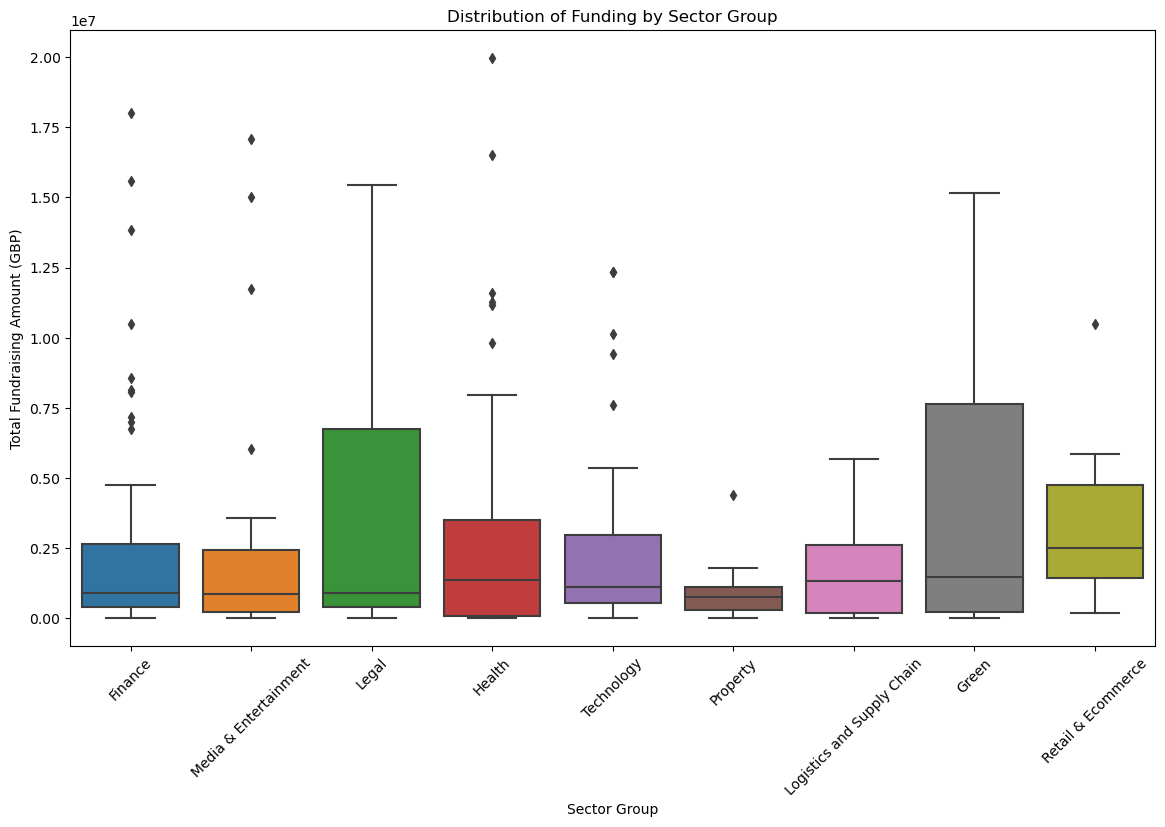

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot to visualize the distribution of funding in each sector group
plt.figure(figsize=(14, 8))
sns.boxplot(x='Sector Group', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', data=final_dataset)
plt.title('Distribution of Funding by Sector Group')
plt.xlabel('Sector Group')
plt.ylabel('Total Fundraising Amount (GBP)')
plt.xticks(rotation=45)
plt.show()

In [77]:
# Check for companies where the fundraising amount is equal to zero
zero_funding_companies = final_dataset[final_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'] == 0]

# Display the number of companies with zero funding
zero_funding_count = zero_funding_companies.shape[0]
print(f"Number of companies with zero funding: {zero_funding_count}")

# Display the companies with zero funding
print(zero_funding_companies)


Number of companies with zero funding: 42
                  Company Name                           Web URL  \
1                PropTechAM.ai                     proptecham.ai   
2                      Dinetic                      dineticq.com   
3                      Colendi                       colendi.com   
4            Simply Regulation                      finreg-e.com   
5                    Cybermind                 cybermindtech.com   
8                    Zupervise                     zupervise.com   
9                    Sermaurei                      sermaurei.uk   
10                      ArchEo            https://www.archai.io/   
11                       DONAA                          donaa.ai   
12                        Dyad                          dyad.net   
15            London Analytics  https://www.londonanalytics.com/   
16                    Bitbloom                     bitbloom.tech   
17                   Kaktus-ai                         kaktus.ai   
18    

In [81]:
# Drop companies where the fundraising amount is equal to zero
final_dataset = final_dataset[final_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'] > 0]

# Display the number of rows in the updated dataset
row_count = final_dataset.shape[0]
print(f"Number of companies after dropping those with zero funding: {row_count}")


Number of companies after dropping those with zero funding: 310


In [83]:
# Get the frequency of each unique sector in 'Sector 1'
sector_frequency = final_dataset['Sector Group'].value_counts()
print("Frequency of unique sector groups':")
print(sector_frequency)

Frequency of unique sector groups':
Sector Group
Health                        83
Finance                       52
Media & Entertainment         37
Technology                    28
Green                         19
Logistics and Supply Chain    12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64


In [89]:
# Export the updated final_dataset to an Excel file
final_dataset.to_excel('final_dataset_no_zero_funding.xlsx', index=False)

In [91]:
# Count the number of rows where the Sector Group is empty
empty_sector_group_count = final_dataset['Sector Group'].isna().sum()
print(f"Number of rows with empty Sector Group: {empty_sector_group_count}")

Number of rows with empty Sector Group: 54


In [93]:
# Remove rows where the Sector Group is empty
final_dataset = final_dataset.dropna(subset=['Sector Group'])

# Display the number of rows in the updated dataset
row_count = final_dataset.shape[0]
print(f"Number of companies after dropping those with empty Sector Group: {row_count}")

# Count the frequency of each sector group in the updated dataset
sector_group_frequency = final_dataset['Sector Group'].value_counts()
print("Frequency of unique sector groups in the final dataset:")
print(sector_group_frequency)

Number of companies after dropping those with empty Sector Group: 256
Frequency of unique sector groups in the final dataset:
Sector Group
Health                        83
Finance                       52
Media & Entertainment         37
Technology                    28
Green                         19
Logistics and Supply Chain    12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64


In [95]:
# Define the sector groups of interest
sector_groups_of_interest = ['Health', 'Finance', 'Media & Entertainment', 'Technology']

# Filter the dataset to include only the rows with the sector groups of interest
filtered_sectors = final_dataset[final_dataset['Sector Group'].isin(sector_groups_of_interest)]

# Group by Sector Group and Sector 1, then count the occurrences
unique_sectors_counts = filtered_sectors.groupby(['Sector Group', 'Sector 1']).size().reset_index(name='Count')

# Display the unique sectors and their counts within the specified sector groups
print("Unique sectors and their counts within specified sector groups:")
print(unique_sectors_counts)

Unique sectors and their counts within specified sector groups:
             Sector Group           Sector 1  Count
0                 Finance   Asset Management      1
1                 Finance            Finance     44
2                 Finance  Financial markets      1
3                 Finance            Fintech      4
4                 Finance          Insurance      2
5                  Health            Biology      1
6                  Health             Health     82
7   Media & Entertainment        Advertising     11
8   Media & Entertainment                Art      1
9   Media & Entertainment      Entertainment      2
10  Media & Entertainment             Gaming      2
11  Media & Entertainment          Marketing     12
12  Media & Entertainment            Martech      2
13  Media & Entertainment              Media      6
14  Media & Entertainment              Sport      1
15             Technology         Automobile      1
16             Technology      Cybersecurity      7


In [97]:
# Update the sector group mapping for 'Martech', 'Advertising', and 'Marketing'
final_dataset.loc[final_dataset['Sector 1'].isin(['Martech', 'Advertising', 'Marketing']), 'Sector Group'] = 'Marketing & Advertising'

In [99]:
# Count the frequency of each sector group in the updated dataset
sector_group_frequency = final_dataset['Sector Group'].value_counts()
print("Frequency of unique sector groups in the final dataset:")
print(sector_group_frequency)

Frequency of unique sector groups in the final dataset:
Sector Group
Health                        83
Finance                       52
Technology                    28
Marketing & Advertising       25
Green                         19
Logistics and Supply Chain    12
Media & Entertainment         12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64


In [101]:
# Drop the 'Purpose 2' column from the final dataset
final_dataset = final_dataset.drop(columns=['Purpose 2'])

# Count the unique 'Purpose 1' values under each 'Sector Group'
unique_purpose_counts = final_dataset.groupby('Sector Group')['Purpose 1'].nunique().reset_index(name='Unique Purpose 1 Count')

# Display the unique 'Purpose 1' counts under each 'Sector Group'
print("Unique 'Purpose 1' counts under each 'Sector Group':")
print(unique_purpose_counts)


Unique 'Purpose 1' counts under each 'Sector Group':
                 Sector Group  Unique Purpose 1 Count
0                     Finance                       6
1                       Green                       3
2                      Health                       7
3                       Legal                       5
4  Logistics and Supply Chain                       4
5     Marketing & Advertising                       6
6       Media & Entertainment                       6
7                    Property                       5
8          Retail & Ecommerce                       5
9                  Technology                       5


In [103]:
# Group by Sector Group and Purpose 1, then count the occurrences
unique_purpose_details = final_dataset.groupby(['Sector Group', 'Purpose 1']).size().reset_index(name='Count')

# Display the unique Purpose 1 values and their counts under each Sector Group
print("Unique 'Purpose 1' values and their counts under each 'Sector Group':")
print(unique_purpose_details)

Unique 'Purpose 1' values and their counts under each 'Sector Group':
                  Sector Group        Purpose 1  Count
0                      Finance  event detection      3
1                      Finance      forecasting     26
2                      Finance       generation      1
3                      Finance     optimisation     10
4                      Finance      recognition      2
5                      Finance           search     10
6                        Green  event detection      7
7                        Green      forecasting      8
8                        Green     optimisation      4
9                       Health  event detection     23
10                      Health      forecasting     25
11                      Health       generation      6
12                      Health     optimisation      7
13                      Health  personalisation      2
14                      Health      recognition     10
15                      Health           search   

In [105]:
# Check the total row count in the final dataset
total_row_count = final_dataset.shape[0]
print(f"Total row count in the final dataset: {total_row_count}")

Total row count in the final dataset: 256


In [107]:
# Count the frequency of each sector group in the updated dataset
sector_group_frequency = final_dataset['Sector Group'].value_counts()
print("Frequency of unique sector groups in the final dataset:")
print(sector_group_frequency)

Frequency of unique sector groups in the final dataset:
Sector Group
Health                        83
Finance                       52
Technology                    28
Marketing & Advertising       25
Green                         19
Logistics and Supply Chain    12
Media & Entertainment         12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64


In [141]:
# Ensure 'Incorporation date (Companies House)' is in datetime format
final_dataset['Incorporation date (Companies House)'] = pd.to_datetime(final_dataset['Incorporation date (Companies House)'], errors='coerce')

# Filter the dataset for incorporation dates after 1st January 2019
filtered_dataset_2019 = final_dataset[final_dataset['Incorporation date (Companies House)'] > '2019-01-01']

# Count the number of rows in the filtered dataset
row_count_date_filtered_2019 = filtered_dataset_2019.shape[0]
print(f"Number of startups with incorporation date after 1st January 2019: {row_count_date_filtered_2019}")

# Count the unique sector groups in the filtered dataset
unique_sector_groups_count_2019 = filtered_dataset_2019['Sector Group'].nunique()
print(f"Number of unique sector groups in the filtered dataset: {unique_sector_groups_count_2019}")

# Display the unique sector groups and their counts
unique_sector_groups_2019 = filtered_dataset_2019['Sector Group'].value_counts()
print("Unique sector groups and their counts in the filtered dataset:")
print(unique_sector_groups_2019)


Number of startups with incorporation date after 1st January 2019: 162
Number of unique sector groups in the filtered dataset: 10
Unique sector groups and their counts in the filtered dataset:
Sector Group
Health                        54
Finance                       29
Technology                    23
Marketing & Advertising       13
Media & Entertainment         11
Green                         11
Logistics and Supply Chain     9
Property                       5
Retail & Ecommerce             4
Legal                          3
Name: count, dtype: int64


In [149]:
# Ensure 'Incorporation date (Companies House)' is in datetime format
final_dataset['Incorporation date (Companies House)'] = pd.to_datetime(final_dataset['Incorporation date (Companies House)'], errors='coerce')

# Define sector groups with different date conditions
sectors_after_2020 = ['Health', 'Finance', 'Technology']
sectors_after_2019 = ['Marketing & Advertising']
sectors_after_2018 = final_dataset[~final_dataset['Sector Group'].isin(sectors_after_2020 + sectors_after_2019)]

# Filter for Health, Finance, and Technology sectors with incorporation date after 1st January 2020
filtered_sectors_2020 = final_dataset[(final_dataset['Sector Group'].isin(sectors_after_2020)) & (final_dataset['Incorporation date (Companies House)'] > '2020-01-01')]

# Filter for Marketing & Advertising sectors with incorporation date after 1st January 2019
filtered_sectors_2019 = final_dataset[(final_dataset['Sector Group'].isin(sectors_after_2019)) & (final_dataset['Incorporation date (Companies House)'] > '2019-01-01')]

# Filter for all other sectors with incorporation date after 1st January 2018
filtered_sectors_2018 = final_dataset[(final_dataset['Sector Group'].isin(sectors_after_2018['Sector Group'])) & (final_dataset['Incorporation date (Companies House)'] > '2018-01-01')]

# Combine all filtered datasets
final_filtered_dataset = pd.concat([filtered_sectors_2020, filtered_sectors_2019, filtered_sectors_2018])

# Display the number of rows in the updated final filtered dataset
row_count = final_filtered_dataset.shape[0]
print(f"Number of companies in the final filtered dataset: {row_count}")

Number of companies in the final filtered dataset: 134


In [151]:
# Count the frequency of each sector group in the updated dataset
sector_group_frequency = final_filtered_dataset['Sector Group'].value_counts()
print("Frequency of unique sector groups in the final dataset:")
print(sector_group_frequency)

Frequency of unique sector groups in the final dataset:
Sector Group
Health                        22
Green                         19
Technology                    16
Finance                       15
Marketing & Advertising       13
Logistics and Supply Chain    12
Media & Entertainment         12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64


In [153]:
# Export the final filtered dataset to an Excel file
final_filtered_dataset.to_excel('final_filtered_dataset.xlsx', index=False)

In [169]:
# Load the Excel file into a pandas DataFrame
file_path = 'ai_startups_dataset.xlsx'
ai_startups_dataset = pd.read_excel(file_path)

# Display the first few rows of the dataset to verify
print(ai_startups_dataset.head())

            Orientation                     Company Name  \
0    automation-focused                            Novai   
1  augmentation-focused                            UNTAP   
2  augmentation-focused                            Kuano   
3  augmentation-focused                        RegGenome   
4  augmentation-focused  iLoF - intelligent Lab on Fiber   

                    Web URL   Sector  \
0  https://www.novai.co.uk/   Health   
1     https://www.untap.pe/  Finance   
2     https://www.kuano.ai/   Health   
3            reg-genome.com  Finance   
4                 ilof.tech   Health   

                                         AI Use Case          Purpose  \
0   AI to detect the DARC biomarker in retina images  event detection   
1  AI predicts the future performance and cash fl...      forecasting   
2  AI to faciliate the addition of quantum mechan...     optimisation   
3  AI predicts and organises relevant financial r...      forecasting   
4  AI predicts type of exosome (a

In [171]:
sector_group_frequency = ai_startups_dataset['Sector Group'].value_counts()

print("Unique broader sector groups and their frequency:")
print(sector_group_frequency)

Unique broader sector groups and their frequency:
Sector Group
Health                        22
Green                         19
Technology                    16
Finance                       15
Marketing & Advertising       13
Logistics and Supply Chain    12
Media & Entertainment         12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64


In [173]:
# Group by 'Sector Group' and 'Augmentation vs Automation' and count the occurrences
split_counts = ai_startups_dataset.groupby(['Sector Group', 'Orientation']).size().reset_index(name='Count')

# Display the split counts
print("Split of automation-focused and augmentation-focused startups within each broader sector group:")
print(split_counts)

Split of automation-focused and augmentation-focused startups within each broader sector group:
                  Sector Group           Orientation  Count
0                      Finance  augmentation-focused      2
1                      Finance    automation-focused     13
2                        Green  augmentation-focused      5
3                        Green    automation-focused     14
4                       Health  augmentation-focused      9
5                       Health    automation-focused     13
6                        Legal  augmentation-focused      2
7                        Legal    automation-focused      7
8   Logistics and Supply Chain  augmentation-focused      1
9   Logistics and Supply Chain    automation-focused     11
10     Marketing & Advertising  augmentation-focused     10
11     Marketing & Advertising    automation-focused      3
12       Media & Entertainment  augmentation-focused     12
13                    Property  augmentation-focused      4
14  

In [175]:
# Count the number of unique values in the 'Orientation' column
unique_orientation_count = ai_startups_dataset['Orientation'].nunique()
print(f"Number of unique values in the 'Orientation' column: {unique_orientation_count}")

# Display the count of each unique value in the 'Orientation' column
orientation_value_counts = ai_startups_dataset['Orientation'].value_counts()
print("Count of each unique value in the 'Orientation' column:")
print(orientation_value_counts)

Number of unique values in the 'Orientation' column: 2
Count of each unique value in the 'Orientation' column:
Orientation
automation-focused      79
augmentation-focused    55
Name: count, dtype: int64


In [177]:
print(ai_startups_dataset.describe())

       Latest pre-money valuation  \
count                1.340000e+02   
mean                 8.019832e+06   
min                  0.000000e+00   
25%                  1.762499e+06   
50%                  3.851061e+06   
75%                  8.088637e+06   
max                  2.638544e+08   
std                  2.356751e+07   

       Fundraisings - Total amount received by the company through fundraisings (GBP)  \
count                                       1.340000e+02                                
mean                                        2.718179e+06                                
min                                         6.000000e+03                                
25%                                         4.217365e+05                                
50%                                         1.190278e+06                                
75%                                         3.142775e+06                                
max                                        

In [179]:
print(ai_startups_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 22 columns):
 #   Column                                                                          Non-Null Count  Dtype         
---  ------                                                                          --------------  -----         
 0   Orientation                                                                     134 non-null    object        
 1   Company Name                                                                    134 non-null    object        
 2   Web URL                                                                         134 non-null    object        
 3   Sector                                                                          134 non-null    object        
 4   AI Use Case                                                                     134 non-null    object        
 5   Purpose                                                                       

In [181]:
# Summary statistics for numerical variables
summary_stats = ai_startups_dataset.describe()
print(summary_stats)

# Frequency counts for categorical variables
sector_counts = ai_startups_dataset['Sector Group'].value_counts()
orientation_counts = ai_startups_dataset['Orientation'].value_counts()

print("Sector Group Counts:\n", sector_counts)
print("Orientation Counts:\n", orientation_counts)

       Latest pre-money valuation  \
count                1.340000e+02   
mean                 8.019832e+06   
min                  0.000000e+00   
25%                  1.762499e+06   
50%                  3.851061e+06   
75%                  8.088637e+06   
max                  2.638544e+08   
std                  2.356751e+07   

       Fundraisings - Total amount received by the company through fundraisings (GBP)  \
count                                       1.340000e+02                                
mean                                        2.718179e+06                                
min                                         6.000000e+03                                
25%                                         4.217365e+05                                
50%                                         1.190278e+06                                
75%                                         3.142775e+06                                
max                                        

In [187]:
from scipy import stats

# Extract funding amounts for both orientations
automation_funding = ai_startups_dataset[ai_startups_dataset['Orientation'] == 'automation-focused']['Fundraisings - Total amount received by the company through fundraisings (GBP)']
augmentation_funding = ai_startups_dataset[ai_startups_dataset['Orientation'] == 'augmentation-focused']['Fundraisings - Total amount received by the company through fundraisings (GBP)']

# Perform T-Test
t_stat, p_val = stats.ttest_ind(automation_funding, augmentation_funding)

print(f"T-Test: t-stat = {t_stat}, p-value = {p_val}")

T-Test: t-stat = -1.1174431988755196, p-value = 0.2658345996014276


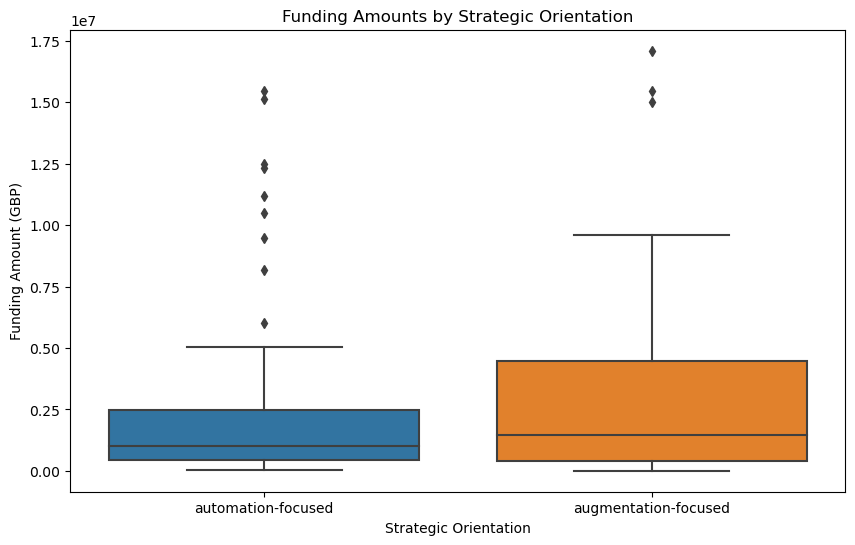

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for funding amounts by orientation
plt.figure(figsize=(10, 6))
sns.boxplot(data=ai_startups_dataset, x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)')
plt.title('Funding Amounts by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Funding Amount (GBP)')
plt.show()

In [191]:
# Create a contingency table
contingency_table = pd.crosstab(ai_startups_dataset['Sector Group'], ai_startups_dataset['Orientation'])
print(contingency_table)

Orientation                 augmentation-focused  automation-focused
Sector Group                                                        
Finance                                        2                  13
Green                                          5                  14
Health                                         9                  13
Legal                                          2                   7
Logistics and Supply Chain                     1                  11
Marketing & Advertising                       10                   3
Media & Entertainment                         12                   0
Property                                       4                   5
Retail & Ecommerce                             4                   3
Technology                                     6                  10


In [193]:
from scipy.stats import chi2_contingency

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 38.11558755392079
P-Value: 1.661837860528247e-05
Degrees of Freedom: 9
Expected Frequencies:
[[ 6.15671642  8.84328358]
 [ 7.79850746 11.20149254]
 [ 9.02985075 12.97014925]
 [ 3.69402985  5.30597015]
 [ 4.92537313  7.07462687]
 [ 5.3358209   7.6641791 ]
 [ 4.92537313  7.07462687]
 [ 3.69402985  5.30597015]
 [ 2.87313433  4.12686567]
 [ 6.56716418  9.43283582]]


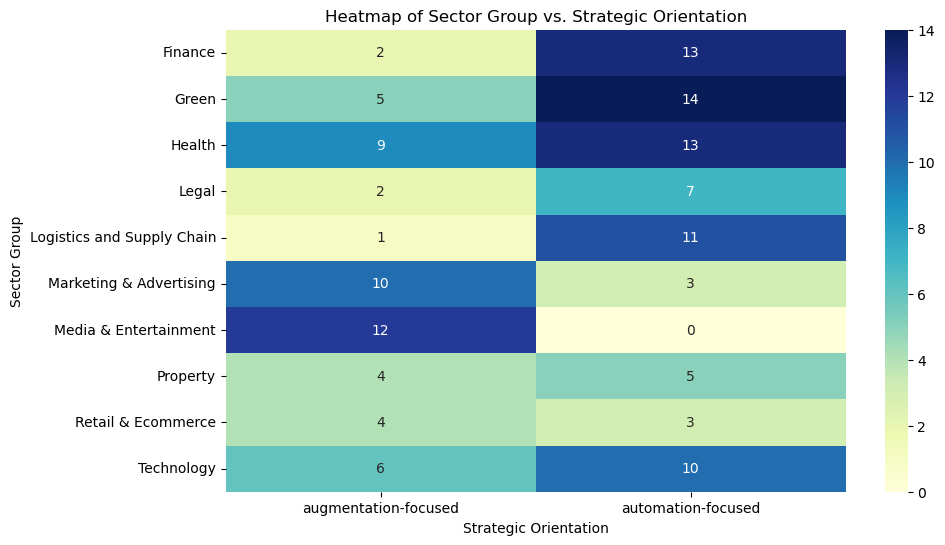

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for the contingency table
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Heatmap of Sector Group vs. Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Sector Group')
plt.show()

In [197]:
# Calculate residuals
residuals = (contingency_table - expected) / expected**0.5
print("Residuals:")
print(residuals)

Residuals:
Orientation                 augmentation-focused  automation-focused
Sector Group                                                        
Finance                                -1.675235            1.397795
Green                                  -1.002122            0.836158
Health                                 -0.009934            0.008289
Legal                                  -0.881396            0.735425
Logistics and Supply Chain             -1.768729            1.475806
Marketing & Advertising                 2.019178           -1.684777
Media & Entertainment                   3.187748           -2.659817
Property                                0.159195           -0.132830
Retail & Ecommerce                      0.664805           -0.554705
Technology                             -0.221320            0.184666


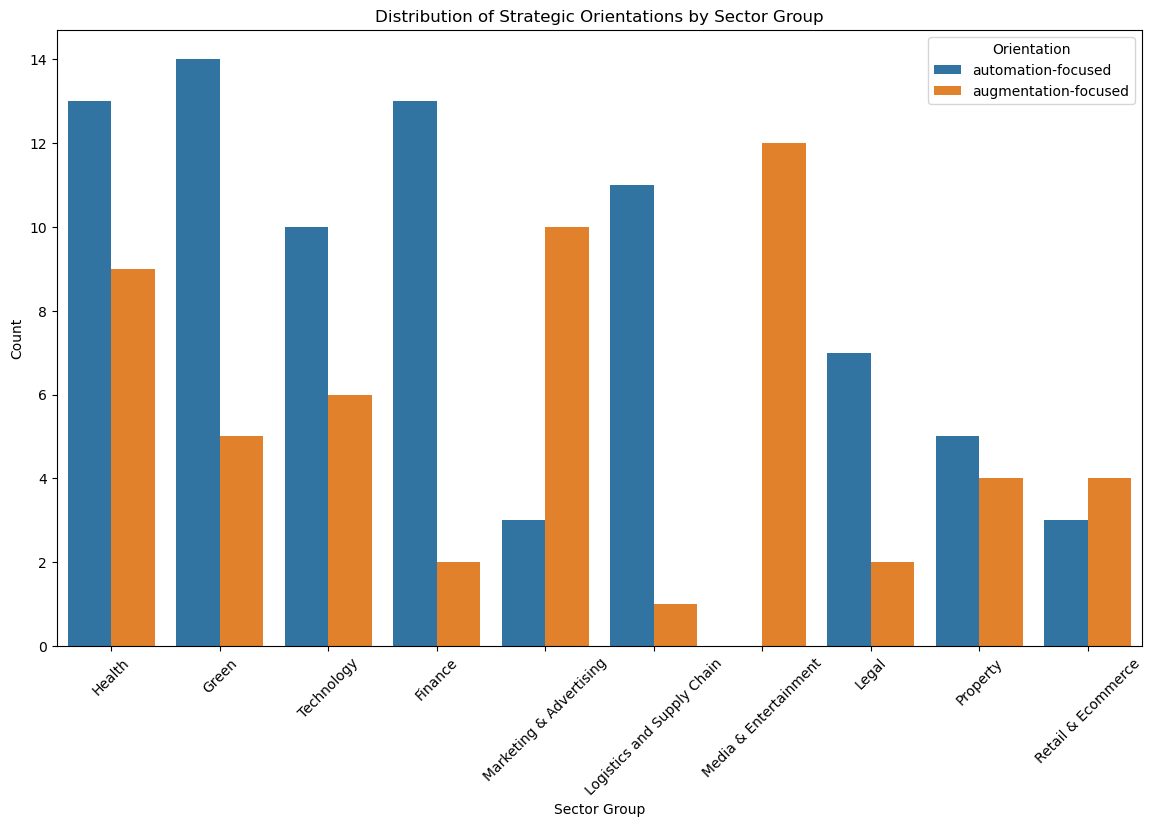

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for sector groups by strategic orientation
plt.figure(figsize=(14, 8))
sns.countplot(data=ai_startups_dataset, x='Sector Group', hue='Orientation', order=ai_startups_dataset['Sector Group'].value_counts().index)
plt.title('Distribution of Strategic Orientations by Sector Group')
plt.xlabel('Sector Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [204]:
from scipy import stats

# Extract funding amounts for both orientations
automation_funding = ai_startups_dataset[ai_startups_dataset['Orientation'] == 'automation-focused']['Fundraisings - Total amount received by the company through fundraisings (GBP)']
augmentation_funding = ai_startups_dataset[ai_startups_dataset['Orientation'] == 'augmentation-focused']['Fundraisings - Total amount received by the company through fundraisings (GBP)']

# Perform T-Test
t_stat, p_val = stats.ttest_ind(automation_funding, augmentation_funding)

print(f"T-Test: t-stat = {t_stat}, p-value = {p_val}")


T-Test: t-stat = -1.1174431988755196, p-value = 0.2658345996014276


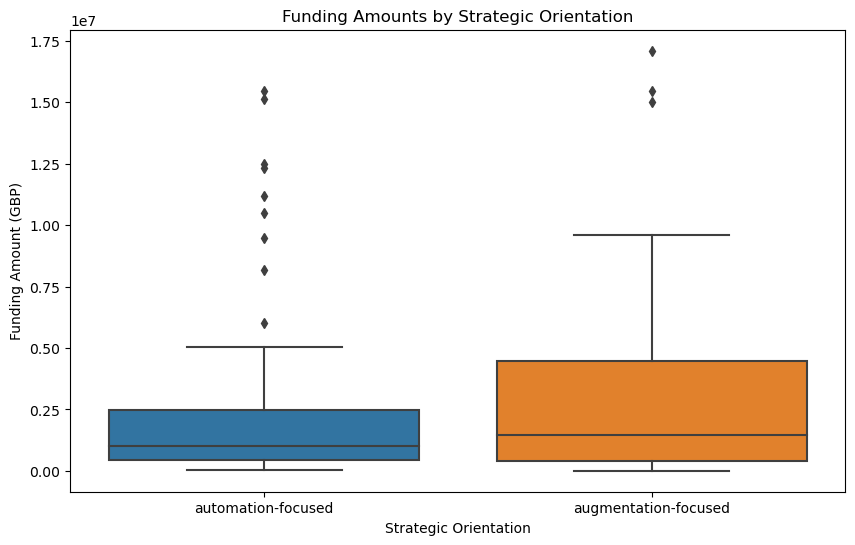

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box plot for funding amounts by orientation
plt.figure(figsize=(10, 6))
sns.boxplot(data=ai_startups_dataset, x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)')
plt.title('Funding Amounts by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Funding Amount (GBP)')
plt.show()


In [210]:
# Group by Sector Group and Orientation and calculate mean and median funding
grouped_funding = ai_startups_dataset.groupby(['Sector Group', 'Orientation'])['Fundraisings - Total amount received by the company through fundraisings (GBP)'].agg(['mean', 'median']).reset_index()
print(grouped_funding)


                  Sector Group           Orientation          mean  \
0                      Finance  augmentation-focused  4.257945e+06   
1                      Finance    automation-focused  1.092923e+06   
2                        Green  augmentation-focused  2.652310e+06   
3                        Green    automation-focused  5.062963e+06   
4                       Health  augmentation-focused  2.484736e+06   
5                       Health    automation-focused  1.329708e+06   
6                        Legal  augmentation-focused  1.252979e+07   
7                        Legal    automation-focused  3.382499e+06   
8   Logistics and Supply Chain  augmentation-focused  5.659560e+06   
9   Logistics and Supply Chain    automation-focused  1.646375e+06   
10     Marketing & Advertising  augmentation-focused  1.389436e+06   
11     Marketing & Advertising    automation-focused  1.263513e+06   
12       Media & Entertainment  augmentation-focused  3.310374e+06   
13                  

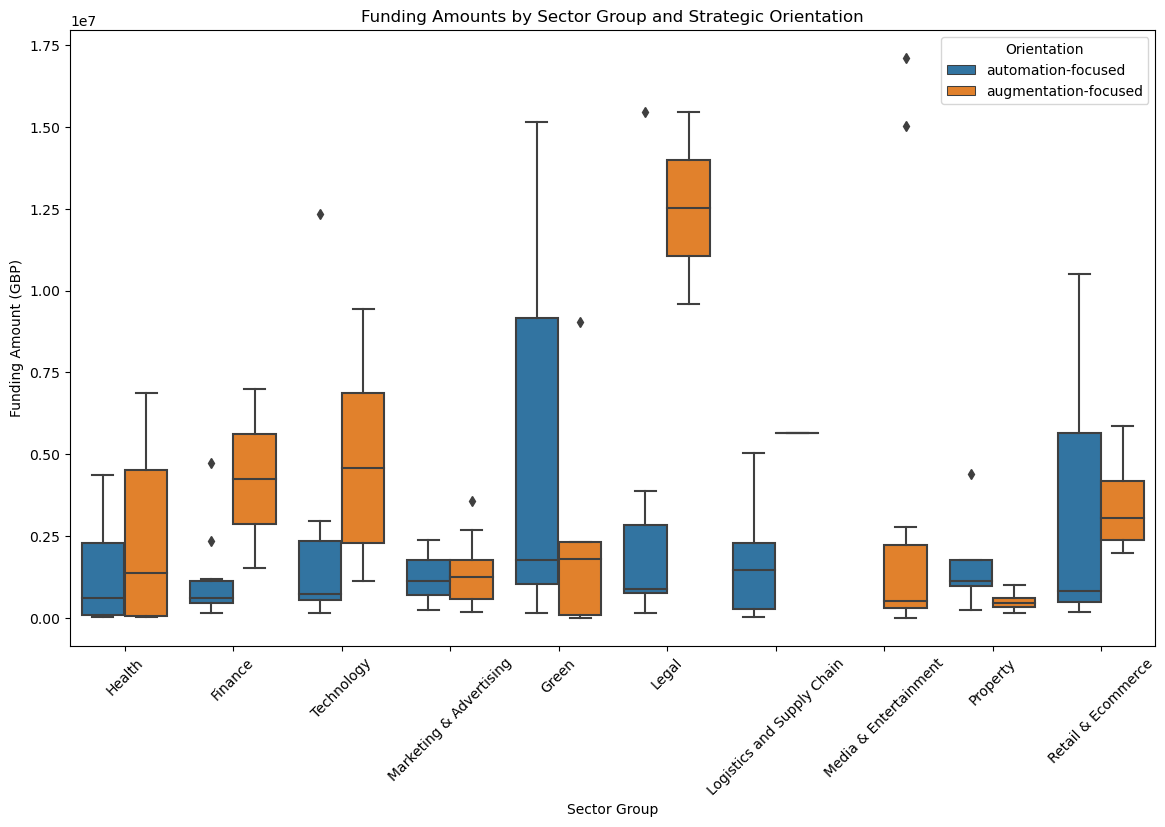

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for funding amounts by sector group and orientation
plt.figure(figsize=(14, 8))
sns.boxplot(data=ai_startups_dataset, x='Sector Group', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', hue='Orientation')
plt.title('Funding Amounts by Sector Group and Strategic Orientation')
plt.xlabel('Sector Group')
plt.ylabel('Funding Amount (GBP)')
plt.xticks(rotation=45)
plt.show()


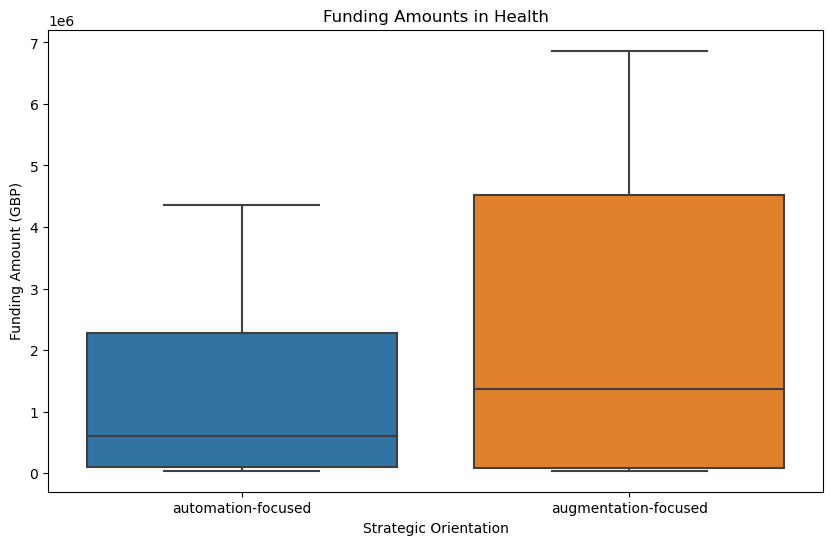

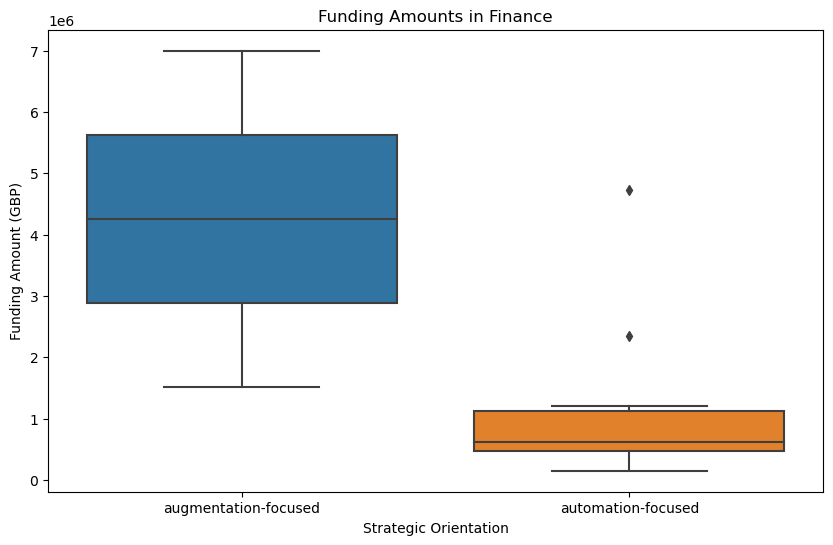

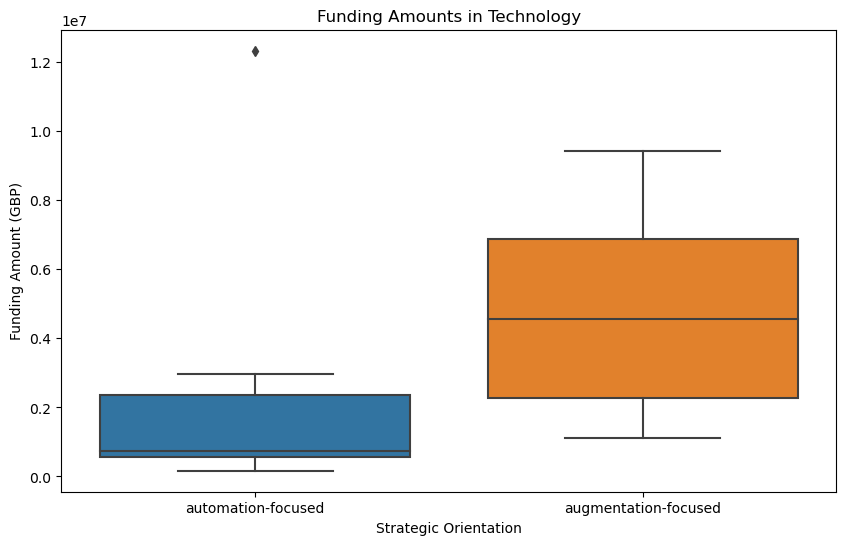

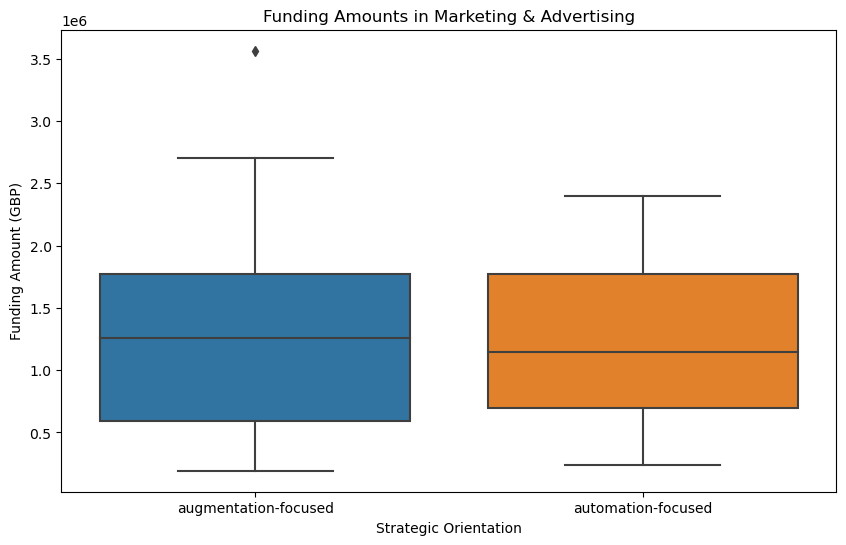

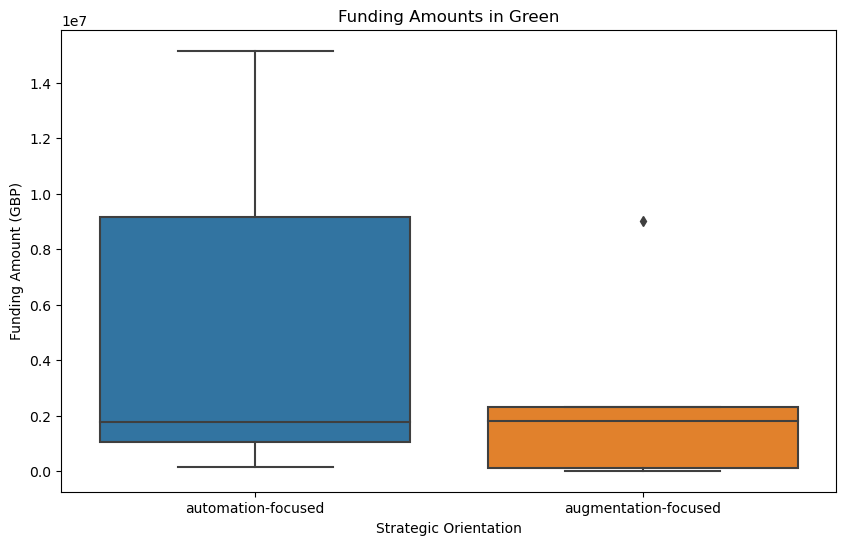

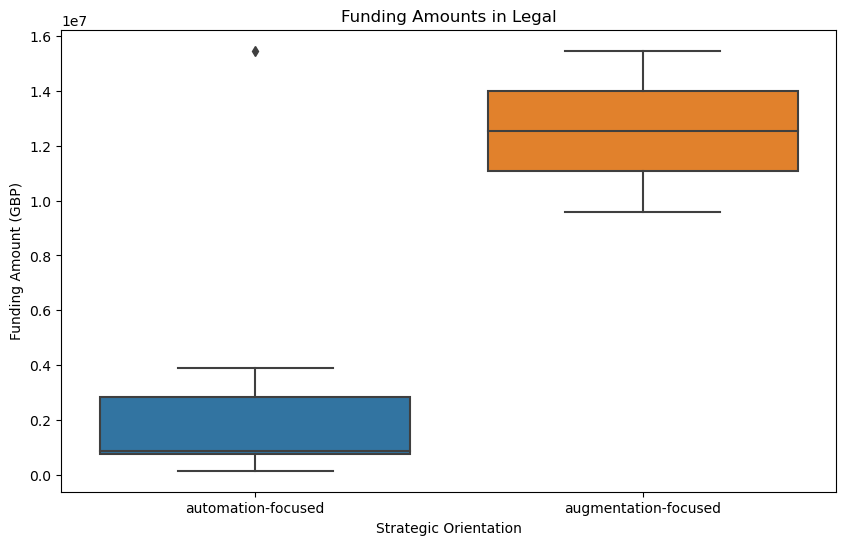

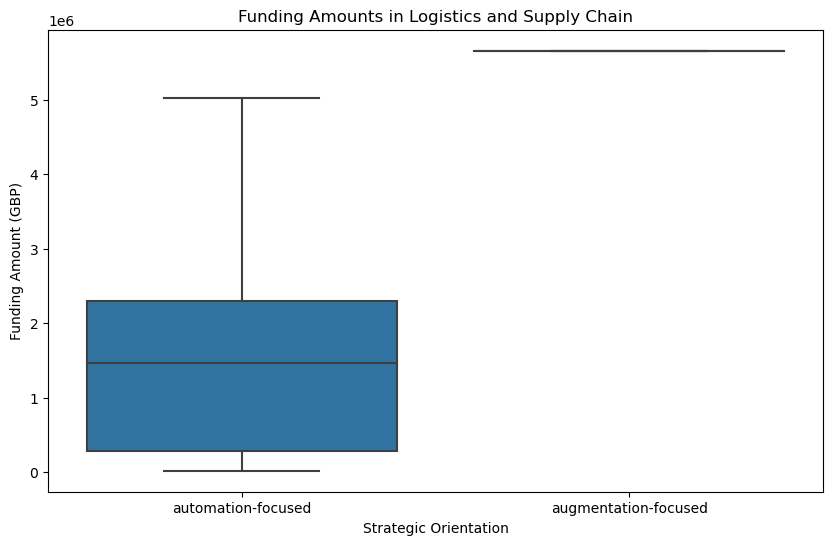

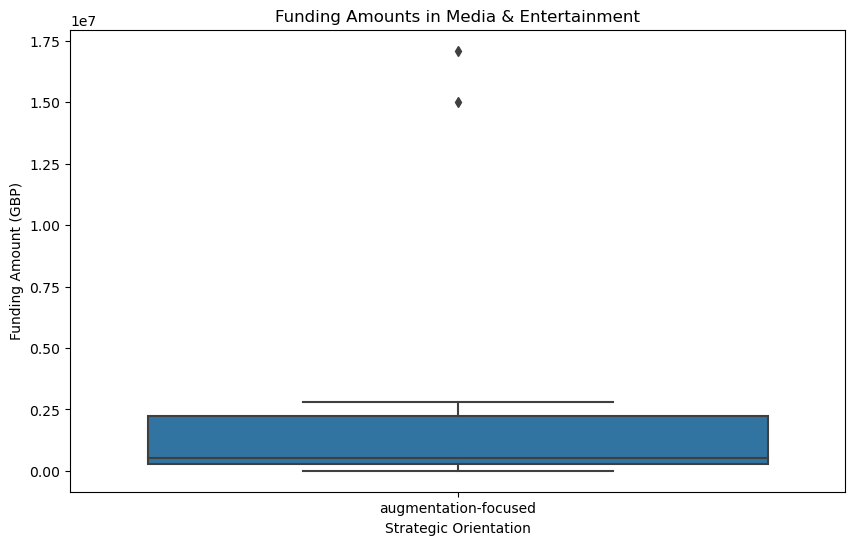

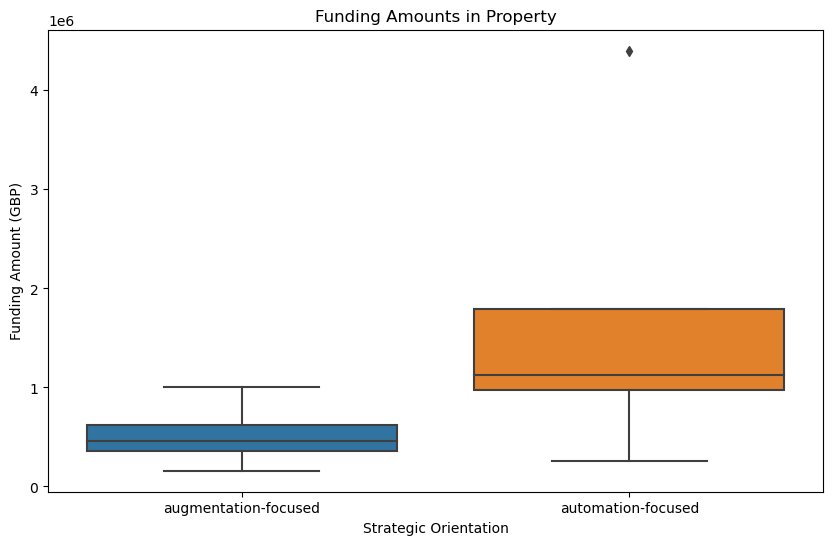

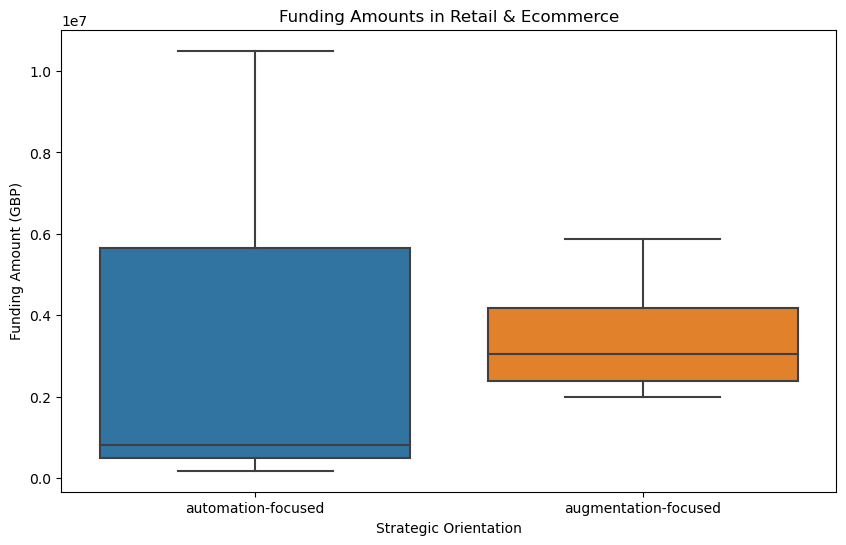

In [214]:
# Create individual plots for each sector group
sector_groups = ai_startups_dataset['Sector Group'].unique()

for sector in sector_groups:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ai_startups_dataset[ai_startups_dataset['Sector Group'] == sector], x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)')
    plt.title(f'Funding Amounts in {sector}')
    plt.xlabel('Strategic Orientation')
    plt.ylabel('Funding Amount (GBP)')
    plt.show()


In [216]:
from scipy import stats

# Get unique sector groups
sector_groups = ai_startups_dataset['Sector Group'].unique()

# Dictionary to store results
t_test_results = {}

# Perform T-Tests for each sector group
for sector in sector_groups:
    sector_data = ai_startups_dataset[ai_startups_dataset['Sector Group'] == sector]
    automation_funding = sector_data[sector_data['Orientation'] == 'automation-focused']['Fundraisings - Total amount received by the company through fundraisings (GBP)']
    augmentation_funding = sector_data[sector_data['Orientation'] == 'augmentation-focused']['Fundraisings - Total amount received by the company through fundraisings (GBP)']
    
    if len(automation_funding) > 1 and len(augmentation_funding) > 1:  # Ensure there are enough data points
        t_stat, p_val = stats.ttest_ind(automation_funding, augmentation_funding, equal_var=False)
        t_test_results[sector] = {'t_stat': t_stat, 'p_val': p_val}

# Display the results
for sector, results in t_test_results.items():
    print(f"Sector: {sector} | T-Statistic: {results['t_stat']:.4f} | P-Value: {results['p_val']:.4f}")

Sector: Health | T-Statistic: -1.1141 | P-Value: 0.2874
Sector: Finance | T-Statistic: -1.1454 | P-Value: 0.4524
Sector: Technology | T-Statistic: -1.4320 | P-Value: 0.1784
Sector: Marketing & Advertising | T-Statistic: -0.1765 | P-Value: 0.8702
Sector: Green | T-Statistic: 1.1114 | P-Value: 0.2920
Sector: Legal | T-Statistic: -2.5497 | P-Value: 0.1169
Sector: Property | T-Statistic: 1.6148 | P-Value: 0.1741
Sector: Retail & Ecommerce | T-Statistic: 0.0979 | P-Value: 0.9300


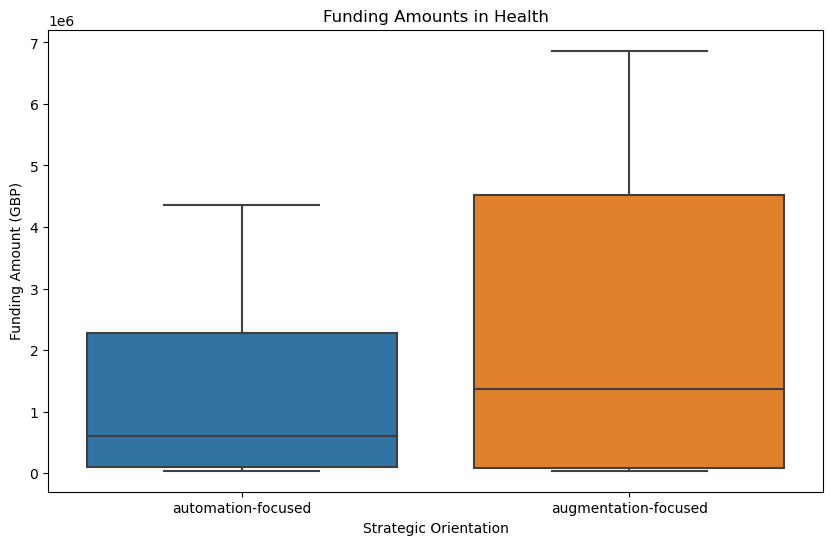

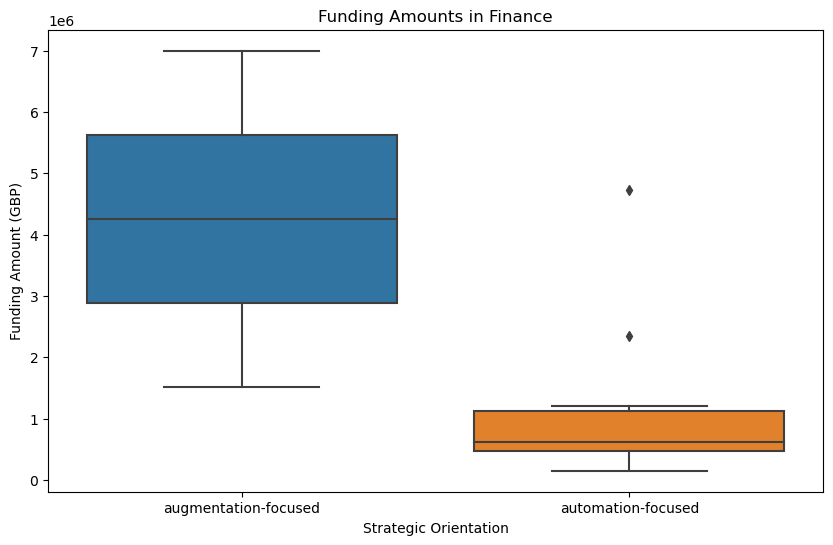

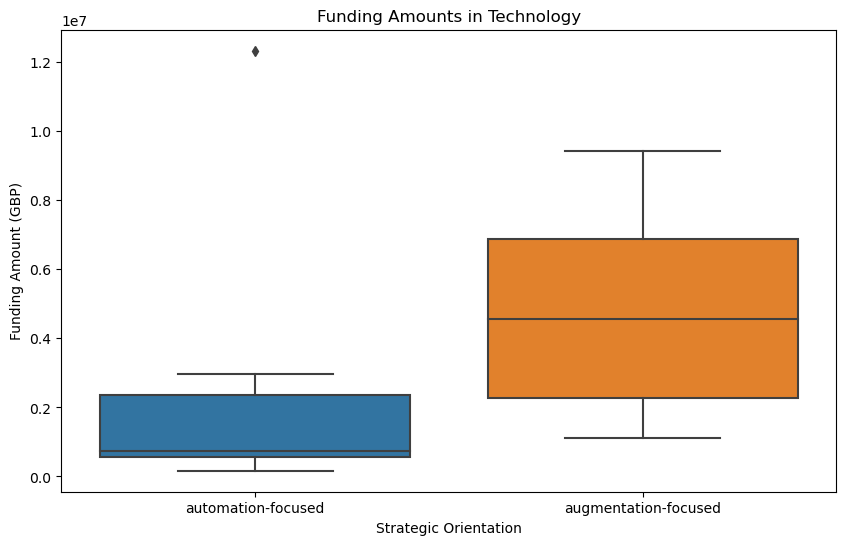

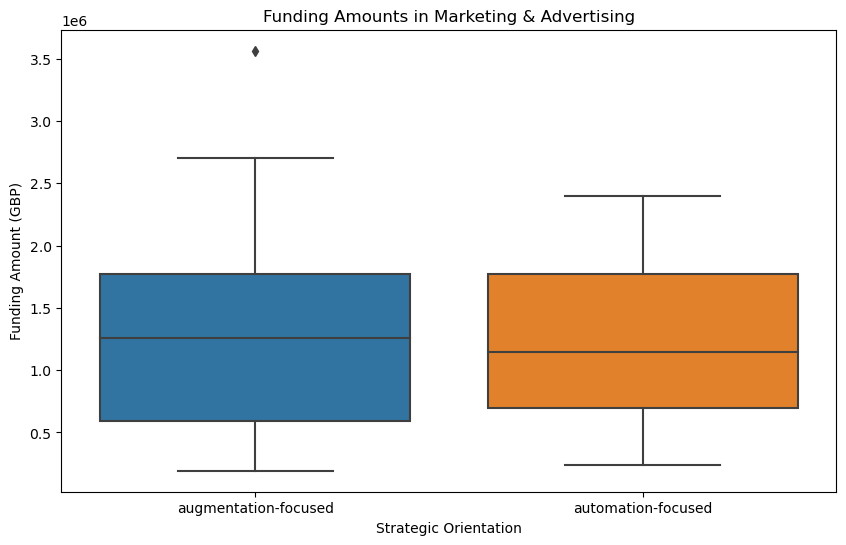

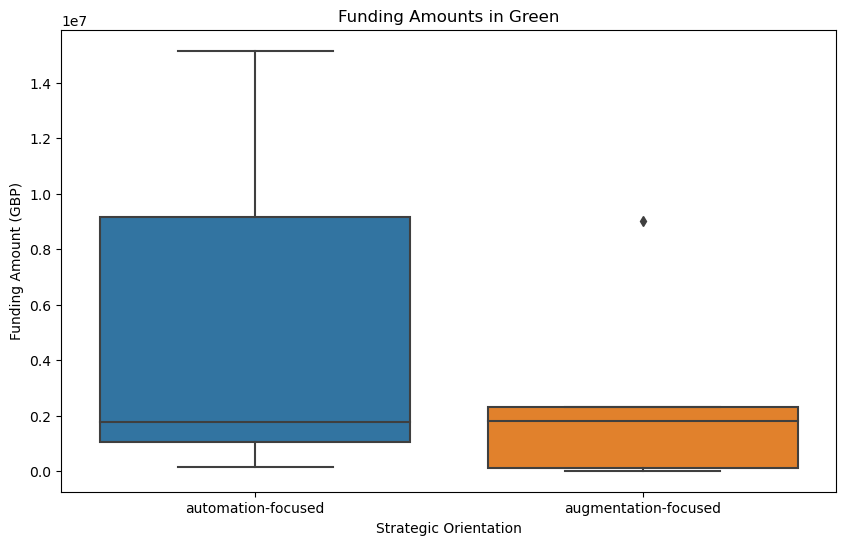

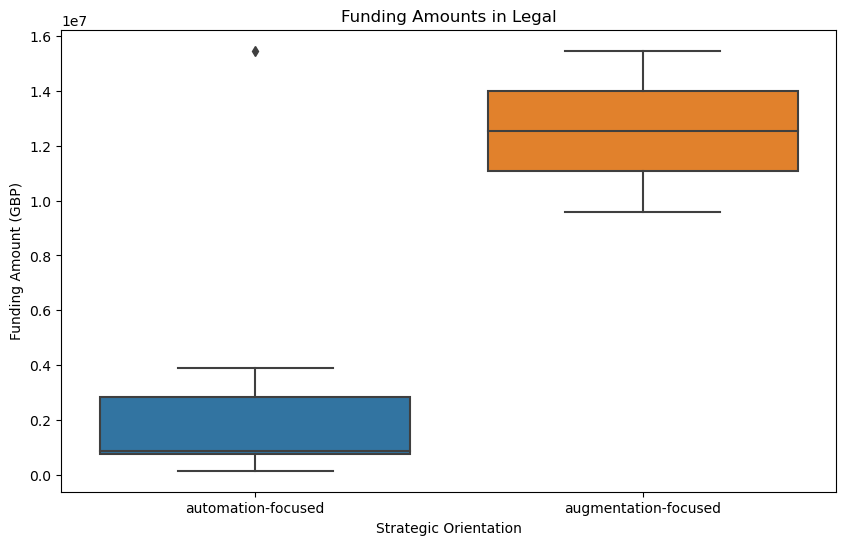

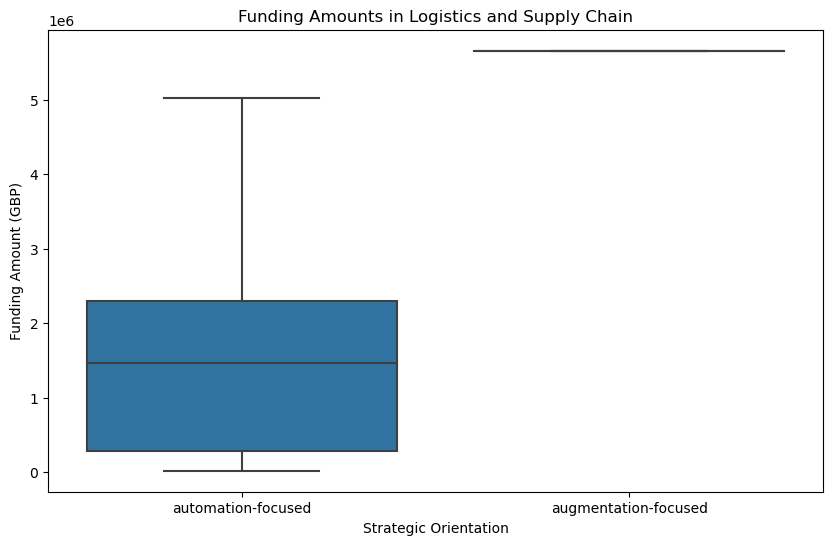

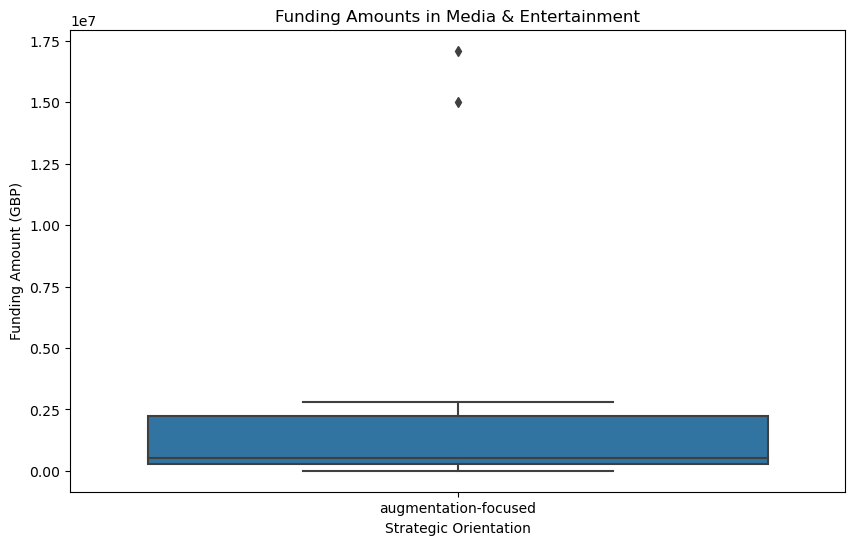

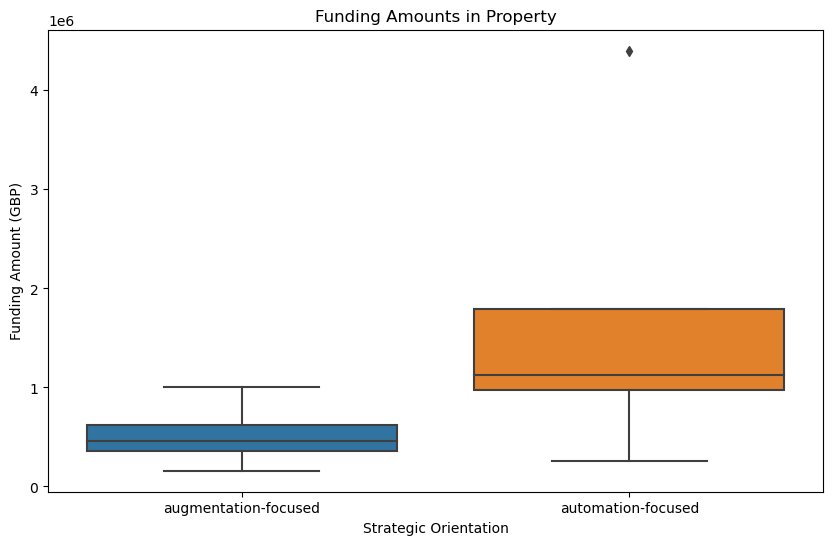

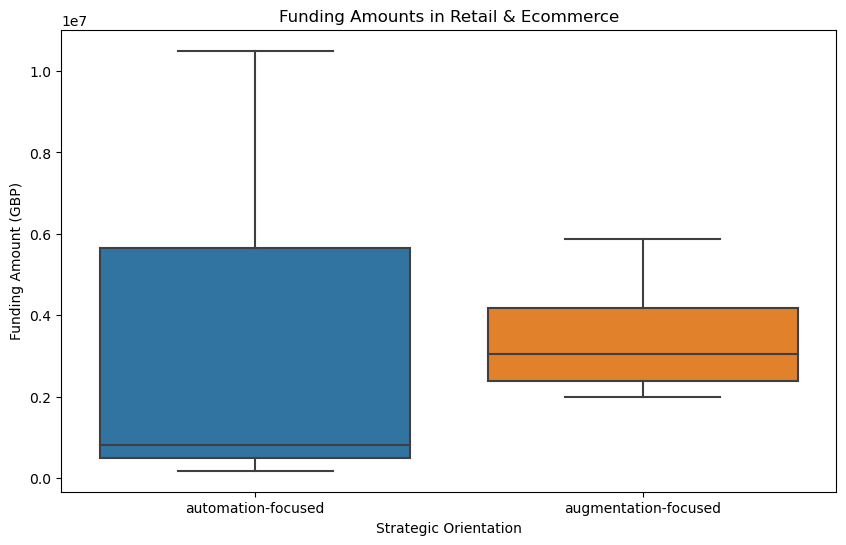

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create individual plots for each sector group
for sector in sector_groups:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ai_startups_dataset[ai_startups_dataset['Sector Group'] == sector], x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)')
    plt.title(f'Funding Amounts in {sector}')
    plt.xlabel('Strategic Orientation')
    plt.ylabel('Funding Amount (GBP)')
    plt.show()

In [222]:
# Create contingency tables
academic_contingency_table = pd.crosstab(ai_startups_dataset['academic_founders'], ai_startups_dataset['Orientation'])
expert_contingency_table = pd.crosstab(ai_startups_dataset['expert_founders'], ai_startups_dataset['Orientation'])
serial_contingency_table = pd.crosstab(ai_startups_dataset['serial_founders'], ai_startups_dataset['Orientation'])

print("Academic Founders Contingency Table:")
print(academic_contingency_table)
print("\nExpert Founders Contingency Table:")
print(expert_contingency_table)
print("\nSerial Founders Contingency Table:")
print(serial_contingency_table)

Academic Founders Contingency Table:
Orientation        augmentation-focused  automation-focused
academic_founders                                          
False                                39                  60
True                                 16                  19

Expert Founders Contingency Table:
Orientation      augmentation-focused  automation-focused
expert_founders                                          
False                              22                  39
True                               33                  40

Serial Founders Contingency Table:
Orientation      augmentation-focused  automation-focused
serial_founders                                          
False                              41                  68
True                               14                  11


In [224]:
from scipy.stats import chi2_contingency

# Chi-Square test for academic founders
chi2_academic, p_academic, dof_academic, expected_academic = chi2_contingency(academic_contingency_table)
print(f"Academic Founders - Chi-Square Statistic: {chi2_academic}, P-Value: {p_academic}")

# Chi-Square test for expert founders
chi2_expert, p_expert, dof_expert, expected_expert = chi2_contingency(expert_contingency_table)
print(f"Expert Founders - Chi-Square Statistic: {chi2_expert}, P-Value: {p_expert}")

# Chi-Square test for serial founders
chi2_serial, p_serial, dof_serial, expected_serial = chi2_contingency(serial_contingency_table)
print(f"Serial Founders - Chi-Square Statistic: {chi2_serial}, P-Value: {p_serial}")

Academic Founders - Chi-Square Statistic: 0.20563590865086825, P-Value: 0.6502096521208202
Expert Founders - Chi-Square Statistic: 0.8006084260181201, P-Value: 0.3709115223916539
Serial Founders - Chi-Square Statistic: 2.1317092513803706, P-Value: 0.1442797915042424


In [227]:
# Frequency counts for categorical variables
sector_counts = ai_startups_dataset['Sector Group'].value_counts()
orientation_counts = ai_startups_dataset['Orientation'].value_counts()

print("\nSector Group Counts:\n", sector_counts)
print("\nOrientation Counts:\n", orientation_counts)



Sector Group Counts:
 Sector Group
Health                        22
Green                         19
Technology                    16
Finance                       15
Marketing & Advertising       13
Logistics and Supply Chain    12
Media & Entertainment         12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64

Orientation Counts:
 Orientation
automation-focused      79
augmentation-focused    55
Name: count, dtype: int64


In [229]:
# Frequency counts for categorical variables
sector_counts = ai_startups_dataset['Sector Group'].value_counts()
orientation_counts = ai_startups_dataset['Orientation'].value_counts()

# Display the frequency counts as tables
print("\nSector Group Counts:\n")
print(sector_counts)

print("\nOrientation Counts:\n")
print(orientation_counts)

# Convert frequency counts to DataFrame for a better table format in Jupyter
sector_counts_df = sector_counts.reset_index().rename(columns={'index': 'Sector Group', 'Sector Group': 'Count'})
orientation_counts_df = orientation_counts.reset_index().rename(columns={'index': 'Orientation', 'Orientation': 'Count'})

print("\nSector Group Counts Table:\n")
display(sector_counts_df)

print("\nOrientation Counts Table:\n")
display(orientation_counts_df)


Sector Group Counts:

Sector Group
Health                        22
Green                         19
Technology                    16
Finance                       15
Marketing & Advertising       13
Logistics and Supply Chain    12
Media & Entertainment         12
Legal                          9
Property                       9
Retail & Ecommerce             7
Name: count, dtype: int64

Orientation Counts:

Orientation
automation-focused      79
augmentation-focused    55
Name: count, dtype: int64

Sector Group Counts Table:



,Count,count
0,Health,22
1,Green,19
2,Technology,16
3,Finance,15
4,Marketing & Advertising,13
5,Logistics and Supply Chain,12
6,Media & Entertainment,12
7,Legal,9
8,Property,9
9,Retail & Ecommerce,7



Orientation Counts Table:



,Count,count
0,automation-focused,79
1,augmentation-focused,55


In [233]:
ai_startups_dataset.head()

,Orientation,Company Name,Web URL,Sector,AI Use Case,Purpose,customer,tech_stack,value,Latest pre-money valuation,...,academic_founders,expert_founders,serial_founders,prolific_investor,large_investor,us_investor,Funding before Q1 2022,Funding after Q1 2022,Incorporation date (Companies House),Sector Group
0,automation-focused,Novai,https://www.novai.co.uk/,Health,AI to detect the DARC biomarker in retina images,event detection,third,sensors,unclear,1.360501e+07,...,True,True,False,1.0,NaN,NaN,9.971827e+06,2.263302e+07,2020-02-12,Health
1,augmentation-focused,UNTAP,https://www.untap.pe/,Finance,AI predicts the future performance and cash fl...,forecasting,b2b,services,unclear,2.475874e+06,...,False,False,True,1.0,NaN,NaN,3.182400e+04,4.595472e+06,2021-04-23,Finance
2,augmentation-focused,Kuano,https://www.kuano.ai/,Health,AI to faciliate the addition of quantum mechan...,optimisation,third,services,unclear,4.119353e+06,...,True,True,True,NaN,NaN,NaN,4.000000e+06,6.508310e+06,2020-02-17,Health
3,augmentation-focused,RegGenome,reg-genome.com,Finance,AI predicts and organises relevant financial r...,forecasting,b2b,api data_management,unclear,1.035370e+07,...,True,True,False,1.0,NaN,1.0,5.699927e+06,3.739987e+07,2020-09-07,Finance
4,augmentation-focused,iLoF - intelligent Lab on Fiber,ilof.tech,Health,"AI predicts type of exosome (a small, membrane...",recognition,b2b,services,unclear,1.221685e+07,...,True,True,False,1.0,1.0,1.0,9.738467e+06,3.333847e+07,2020-05-22,Health


Descriptive Statistics for Total Funding Amounts by Strategic Orientation:

                      count          mean           std      min         25%  \
Orientation                                                                    
augmentation-focused   55.0  2.161507e+07  3.593898e+07  31500.0  3092096.08   
automation-focused     79.0  1.540174e+07  2.462477e+07  20000.0  2675000.00   

                               50%           75%           max  
Orientation                                                     
augmentation-focused  1.149309e+07  2.588563e+07  2.419744e+08  
automation-focused    5.383018e+06  1.421164e+07  1.155160e+08  


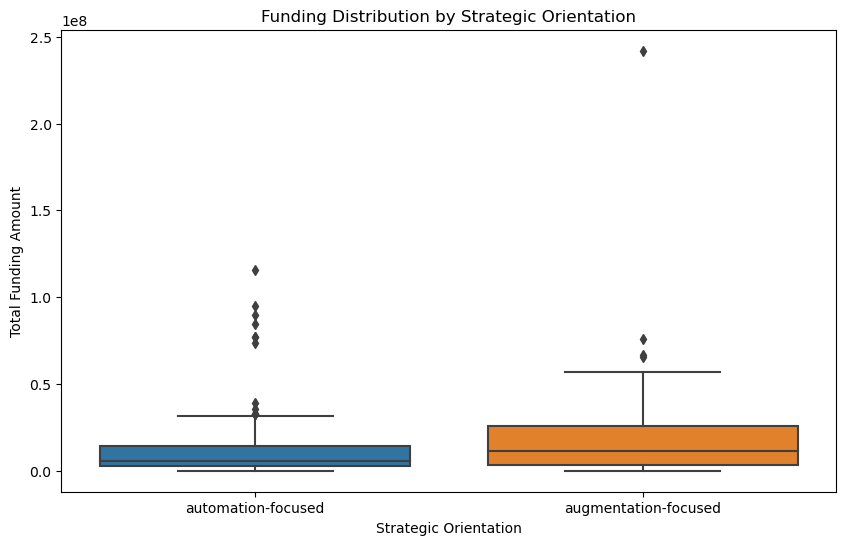

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Combine funding columns to get the total funding amount
ai_startups_dataset['Total Funding'] = ai_startups_dataset['Funding before Q1 2022'] + ai_startups_dataset['Funding after Q1 2022']

# Calculate descriptive statistics for funding amounts by strategic orientation
funding_stats = ai_startups_dataset.groupby('Orientation')['Total Funding'].describe()
print("Descriptive Statistics for Total Funding Amounts by Strategic Orientation:\n")
print(funding_stats)

# Plot the distribution of funding amounts by strategic orientation
plt.figure(figsize=(10, 6))
sns.boxplot(x='Orientation', y='Total Funding', data=ai_startups_dataset)
plt.title('Funding Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Total Funding Amount')
plt.show()

Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:

                      count          mean           std      min  \
Orientation                                                        
augmentation-focused   55.0  3.152666e+06  4.056207e+06   6000.0   
automation-focused     79.0  2.415688e+06  3.532406e+06  20000.0   

                               25%          50%           75%          max  
Orientation                                                                 
augmentation-focused  409449.14305  1446574.307  4.460359e+06  17100000.00  
automation-focused    446923.07055  1000000.000  2.486947e+06  15462863.87  


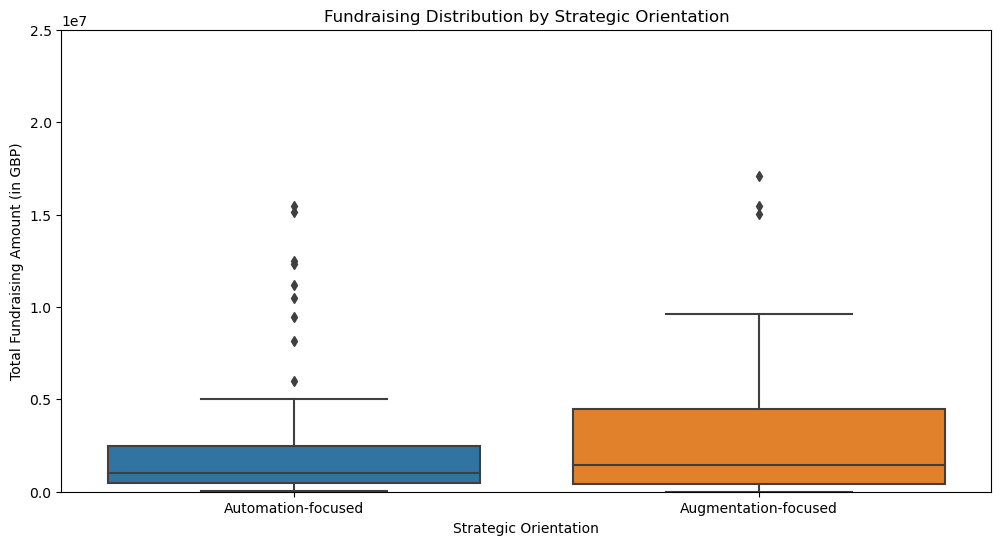

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Calculate descriptive statistics for funding amounts by strategic orientation
funding_stats = ai_startups_dataset.groupby('Orientation')['Fundraisings - Total amount received by the company through fundraisings (GBP)'].describe()
print("Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:\n")
print(funding_stats)

# Plot the distribution of fundraising amounts by strategic orientation with improved labels
plt.figure(figsize=(12, 6))
sns.boxplot(x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', data=ai_startups_dataset)
plt.title('Fundraising Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Total Fundraising Amount (in GBP)')
plt.xticks([0, 1], ['Automation-focused', 'Augmentation-focused'])  # Improve x-axis labels
plt.ylim(0, 2.5e7)  # Adjust y-axis limit based on the data
plt.show()

Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:

                      count          mean           std      min  \
Orientation                                                        
augmentation-focused   55.0  3.152666e+06  4.056207e+06   6000.0   
automation-focused     79.0  2.415688e+06  3.532406e+06  20000.0   

                               25%          50%           75%          max  
Orientation                                                                 
augmentation-focused  409449.14305  1446574.307  4.460359e+06  17100000.00  
automation-focused    446923.07055  1000000.000  2.486947e+06  15462863.87  


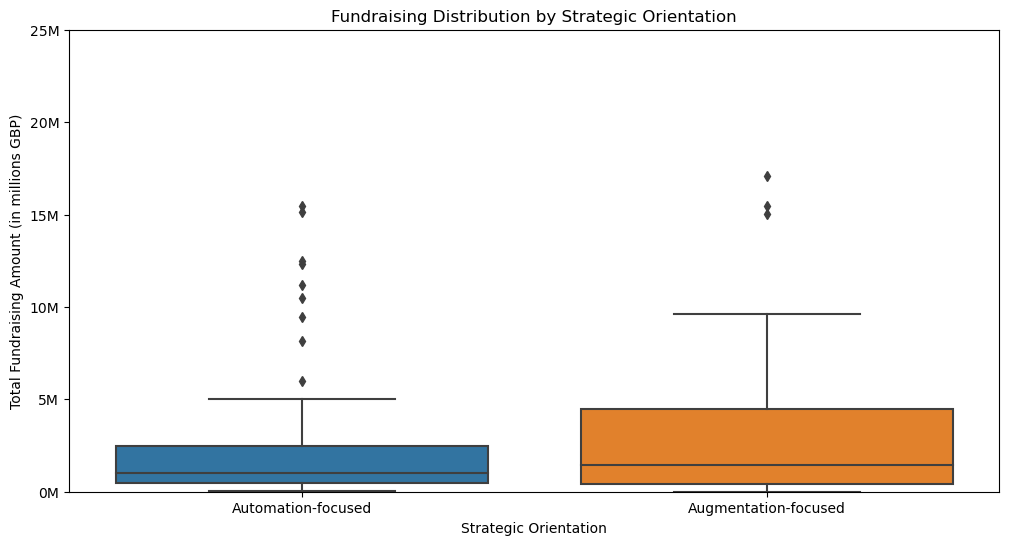

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Calculate descriptive statistics for funding amounts by strategic orientation
funding_stats = ai_startups_dataset.groupby('Orientation')['Fundraisings - Total amount received by the company through fundraisings (GBP)'].describe()
print("Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:\n")
print(funding_stats)

# Ensure the funding column is numeric
ai_startups_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'] = pd.to_numeric(ai_startups_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'], errors='coerce')

# Generate the plot again with y-axis values in millions
plt.figure(figsize=(12, 6))
sns.boxplot(x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', data=ai_startups_dataset)
plt.title('Fundraising Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Total Fundraising Amount (in millions GBP)')
plt.xticks([0, 1], ['Automation-focused', 'Augmentation-focused'])  # Improve x-axis labels

# Adjust y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1e6)) + 'M'))
plt.ylim(0, 2.5e7)  # Adjust y-axis limit based on the data

plt.show()


Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:

                      count          mean           std      min  \
Orientation                                                        
augmentation-focused   55.0  3.152666e+06  4.056207e+06   6000.0   
automation-focused     79.0  2.415688e+06  3.532406e+06  20000.0   

                               25%          50%           75%          max  
Orientation                                                                 
augmentation-focused  409449.14305  1446574.307  4.460359e+06  17100000.00  
automation-focused    446923.07055  1000000.000  2.486947e+06  15462863.87  


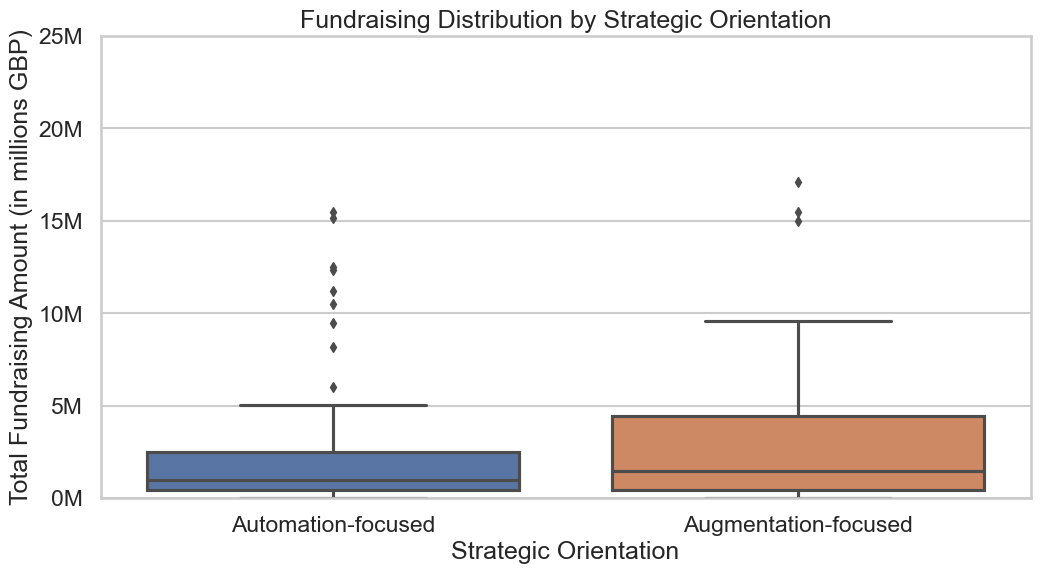

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Calculate descriptive statistics for funding amounts by strategic orientation
funding_stats = ai_startups_dataset.groupby('Orientation')['Fundraisings - Total amount received by the company through fundraisings (GBP)'].describe()
print("Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:\n")
print(funding_stats)

# Ensure the funding column is numeric
ai_startups_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'] = pd.to_numeric(ai_startups_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'], errors='coerce')

# Generate the plot again with y-axis values in millions
plt.figure(figsize=(12, 6))
sns.boxplot(x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', data=ai_startups_dataset)
plt.title('Fundraising Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Total Fundraising Amount (in millions GBP)')
plt.xticks([0, 1], ['Automation-focused', 'Augmentation-focused'])  # Improve x-axis labels

# Adjust y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1e6)) + 'M'))
plt.ylim(0, 2.5e7)  # Adjust y-axis limit based on the data

plt.show()


Sector Distribution by Strategic Orientation:

Orientation                 augmentation-focused  automation-focused
Sector Group                                                        
Finance                                      2.0                13.0
Green                                        5.0                14.0
Health                                       9.0                13.0
Legal                                        2.0                 7.0
Logistics and Supply Chain                   1.0                11.0
Marketing & Advertising                     10.0                 3.0
Media & Entertainment                       12.0                 0.0
Property                                     4.0                 5.0
Retail & Ecommerce                           4.0                 3.0
Technology                                   6.0                10.0


/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/2925063198.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

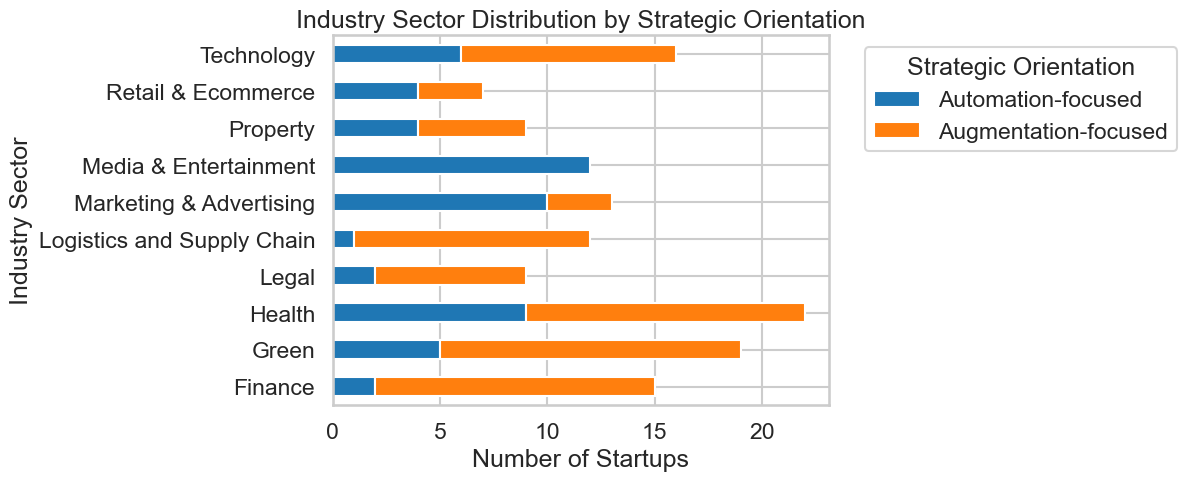

In [263]:
# Frequency counts for sector distribution by strategic orientation
sector_counts = ai_startups_dataset.groupby(['Sector Group', 'Orientation']).size().unstack().fillna(0)
print("Sector Distribution by Strategic Orientation:\n")
print(sector_counts)

# Define custom colors for the bar chart
colors = ['#1f77b4', '#ff7f0e']  # Blue for automation-focused, Orange for augmentation-focused

# Plot the sector distribution as a horizontal bar chart with custom colors
plt.figure(figsize=(14, 8))
sector_counts.plot(kind='barh', stacked=True, color=colors)
plt.title('Industry Sector Distribution by Strategic Orientation')
plt.xlabel('Number of Startups')
plt.ylabel('Industry Sector')
plt.legend(title='Strategic Orientation', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['Automation-focused', 'Augmentation-focused'])
plt.tight_layout()
plt.show()


Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:

                      count          mean           std      min  \
Orientation                                                        
augmentation-focused   55.0  3.152666e+06  4.056207e+06   6000.0   
automation-focused     79.0  2.415688e+06  3.532406e+06  20000.0   

                               25%          50%           75%          max  
Orientation                                                                 
augmentation-focused  409449.14305  1446574.307  4.460359e+06  17100000.00  
automation-focused    446923.07055  1000000.000  2.486947e+06  15462863.87  


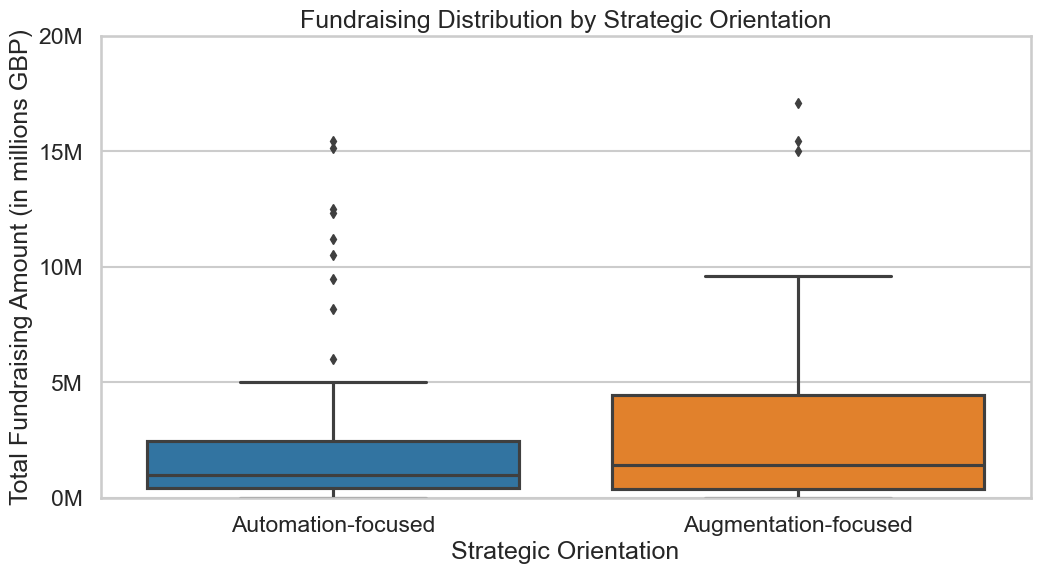

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Calculate descriptive statistics for funding amounts by strategic orientation
funding_stats = ai_startups_dataset.groupby('Orientation')['Fundraisings - Total amount received by the company through fundraisings (GBP)'].describe()
print("Descriptive Statistics for Total Fundraising Amounts by Strategic Orientation:\n")
print(funding_stats)

# Ensure the funding column is numeric
ai_startups_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'] = pd.to_numeric(ai_startups_dataset['Fundraisings - Total amount received by the company through fundraisings (GBP)'], errors='coerce')

# Generate the box plot with custom colors
plt.figure(figsize=(12, 6))
sns.boxplot(x='Orientation', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', data=ai_startups_dataset, palette={'automation-focused': '#1f77b4', 'augmentation-focused': '#ff7f0e'})
plt.title('Fundraising Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Total Fundraising Amount (in millions GBP)')
plt.xticks([0, 1], ['Automation-focused', 'Augmentation-focused'])  # Improve x-axis labels

# Adjust y-axis to show values in millions with a scale of 5 million
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1e6)) + 'M'))
plt.yticks([0, 5e6, 1e7, 1.5e7, 2e7])
plt.ylim(0, 2e7)  # Adjust y-axis limit based on the data

plt.show()


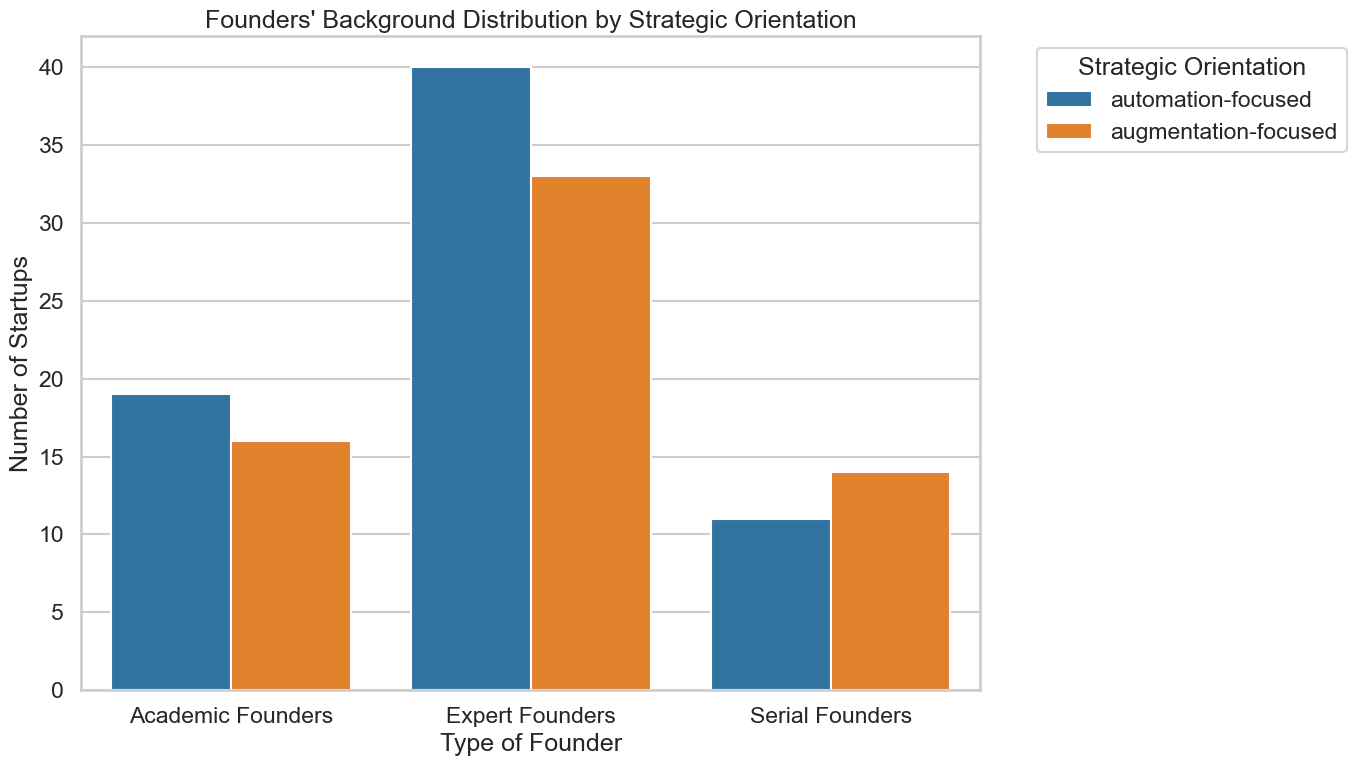

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Define custom colors for the bar charts
colors = {'automation-focused': '#1f77b4', 'augmentation-focused': '#ff7f0e'}

# Prepare the data for plotting
data = {
    'Founder Type': ['Academic Founders', 'Academic Founders', 'Expert Founders', 'Expert Founders', 'Serial Founders', 'Serial Founders'],
    'Orientation': ['automation-focused', 'augmentation-focused', 'automation-focused', 'augmentation-focused', 'automation-focused', 'augmentation-focused'],
    'Count': [
        ai_startups_dataset[(ai_startups_dataset['academic_founders'] == True) & (ai_startups_dataset['Orientation'] == 'automation-focused')].shape[0],
        ai_startups_dataset[(ai_startups_dataset['academic_founders'] == True) & (ai_startups_dataset['Orientation'] == 'augmentation-focused')].shape[0],
        ai_startups_dataset[(ai_startups_dataset['expert_founders'] == True) & (ai_startups_dataset['Orientation'] == 'automation-focused')].shape[0],
        ai_startups_dataset[(ai_startups_dataset['expert_founders'] == True) & (ai_startups_dataset['Orientation'] == 'augmentation-focused')].shape[0],
        ai_startups_dataset[(ai_startups_dataset['serial_founders'] == True) & (ai_startups_dataset['Orientation'] == 'automation-focused')].shape[0],
        ai_startups_dataset[(ai_startups_dataset['serial_founders'] == True) & (ai_startups_dataset['Orientation'] == 'augmentation-focused')].shape[0]
    ]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='Founder Type', y='Count', hue='Orientation', data=df, palette=colors)
plt.title('Founders\' Background Distribution by Strategic Orientation')
plt.xlabel('Type of Founder')
plt.ylabel('Number of Startups')
plt.xticks(rotation=0)
plt.legend(title='Strategic Orientation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


Sector Distribution by Strategic Orientation:

Orientation                 augmentation-focused  automation-focused
Sector Group                                                        
Finance                                      2.0                13.0
Green                                        5.0                14.0
Health                                       9.0                13.0
Legal                                        2.0                 7.0
Logistics and Supply Chain                   1.0                11.0
Marketing & Advertising                     10.0                 3.0
Media & Entertainment                       12.0                 0.0
Property                                     4.0                 5.0
Retail & Ecommerce                           4.0                 3.0
Technology                                   6.0                10.0
Chi-square test results:
chi2 = 38.11558755392079, p-value = 1.661837860528247e-05, degrees of freedom = 9


/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/2720870711.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

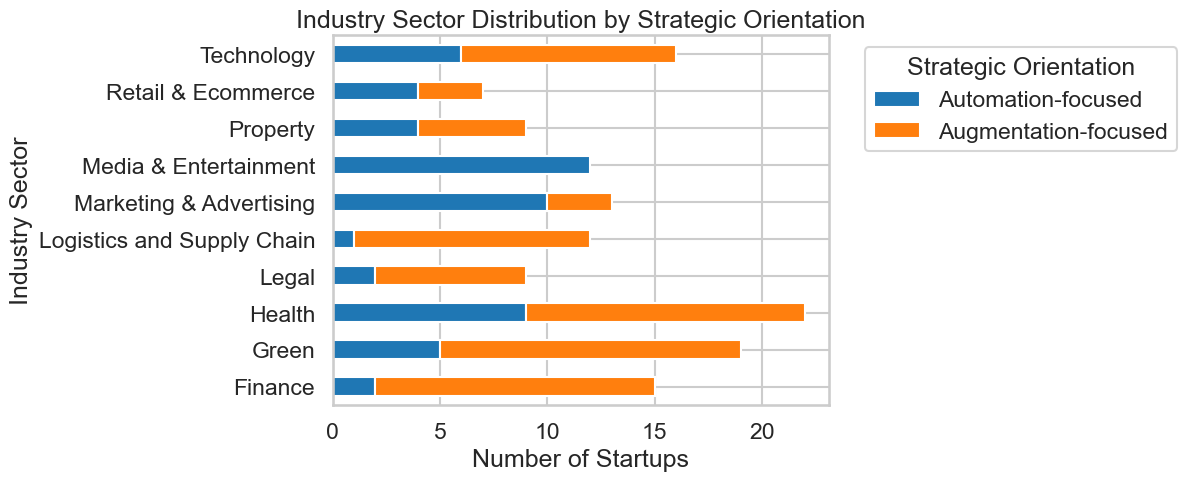

In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load the dataset (assuming it is already loaded)
# ai_startups_dataset = pd.read_csv('your_dataset.csv')

# Frequency counts for sector distribution by strategic orientation
sector_orientation_counts = ai_startups_dataset.groupby(['Sector Group', 'Orientation']).size().unstack().fillna(0)
print("Sector Distribution by Strategic Orientation:\n")
print(sector_orientation_counts)

# Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(sector_orientation_counts)
print(f"Chi-square test results:\nchi2 = {chi2}, p-value = {p}, degrees of freedom = {dof}")

# Plot the sector distribution as a horizontal bar chart with custom colors
colors = ['#1f77b4', '#ff7f0e']  # Blue for automation-focused, Orange for augmentation-focused
plt.figure(figsize=(14, 8))
sector_orientation_counts.plot(kind='barh', stacked=True, color=colors)
plt.title('Industry Sector Distribution by Strategic Orientation')
plt.xlabel('Number of Startups')
plt.ylabel('Industry Sector')
plt.legend(title='Strategic Orientation', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['Automation-focused', 'Augmentation-focused'])
plt.tight_layout()
plt.show()


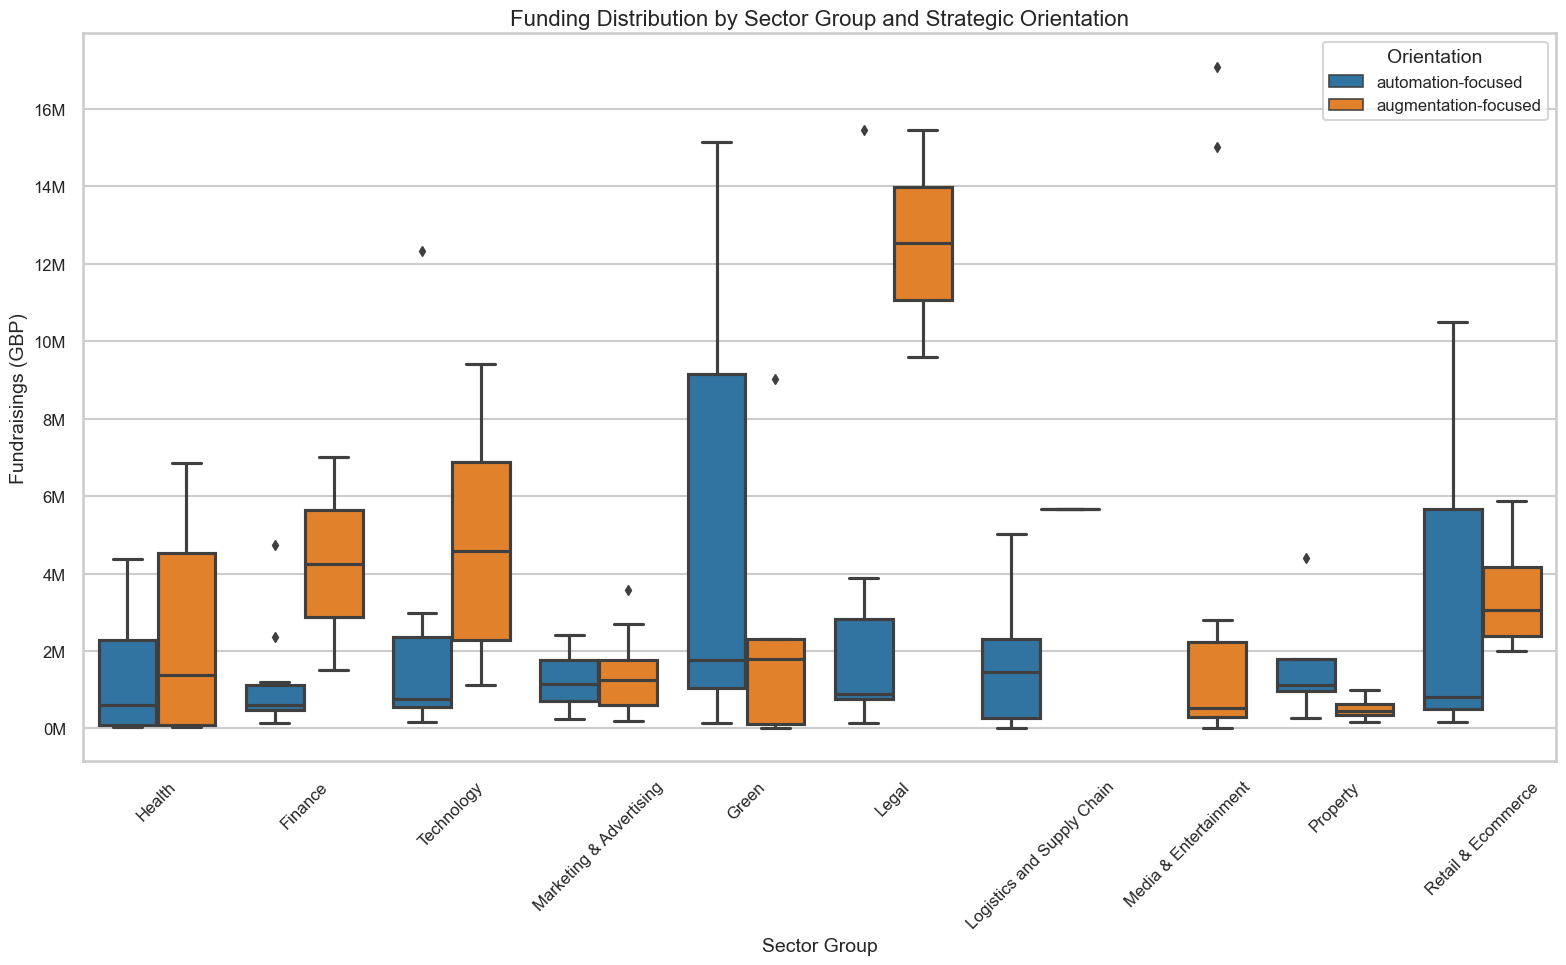

In [298]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors
colors = ['#1f77b4', '#ff7f0e']  # Blue for automation-focused, Orange for augmentation-focused

# 6. Funding distribution by sector group and strategic orientation
plt.figure(figsize=(16, 10))
sns.boxplot(data=ai_startups_dataset, x='Sector Group', y='Fundraisings - Total amount received by the company through fundraisings (GBP)', hue='Orientation', palette=colors)
plt.title('Funding Distribution by Sector Group and Strategic Orientation', fontsize=16)
plt.xlabel('Sector Group', fontsize=14)
plt.ylabel('Fundraisings (GBP)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Orientation', loc='upper right', fontsize=12, title_fontsize=14)

# Custom y-axis labels
y_labels = [f'{int(x)}M' for x in range(0, 18, 2)]
y_ticks = [x * 1e6 for x in range(0, 18, 2)]
plt.yticks(ticks=y_ticks, labels=y_labels)

plt.tight_layout()
plt.show()


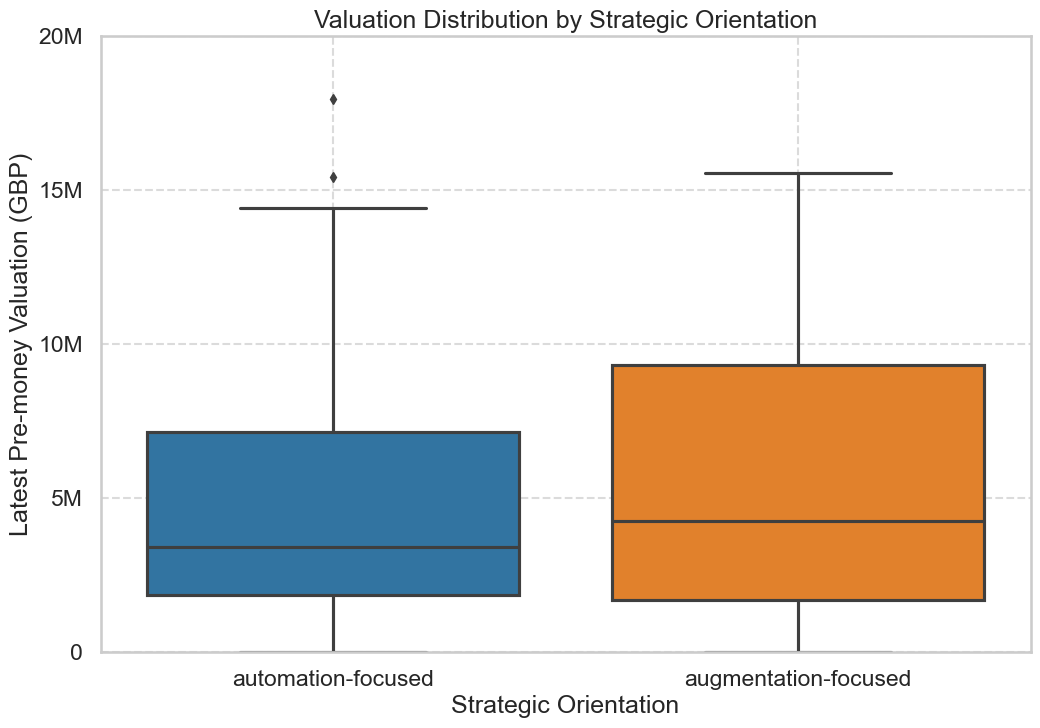

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting the color palette to fit the desired color code
colors = ['#1f77b4', '#ff7f0e']  # Blue for automation-focused, Orange for augmentation-focused

# Plotting the boxplot for valuation distribution
plt.figure(figsize=(12, 8))
sns.boxplot(data=ai_startups_dataset, x='Orientation', y='Latest pre-money valuation', palette=colors)
plt.title('Valuation Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Latest Pre-money Valuation (GBP)')
plt.ylim(0, 2e7)  # Adjust the limits to fit your expected valuation range
plt.yticks([0, 5e6, 10e6, 15e6, 20e6], ['0', '5M', '10M', '15M', '20M'])

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [308]:
import pandas as pd

# Calculate the mean, maximum, and median for each strategic orientation
valuation_stats = ai_startups_dataset.groupby('Orientation')['Latest pre-money valuation'].agg(['mean', 'max', 'median']).reset_index()

# Rename columns for clarity
valuation_stats.columns = ['Strategic Orientation', 'Mean Valuation (GBP)', 'Max Valuation (GBP)', 'Median Valuation (GBP)']

# Display the results
print(valuation_stats)


  Strategic Orientation  Mean Valuation (GBP)  Max Valuation (GBP)  \
0  augmentation-focused          6.502251e+06           54003998.5   
1    automation-focused          9.076376e+06          263854421.2   

   Median Valuation (GBP)  
0             4249421.254  
1             3412500.000  


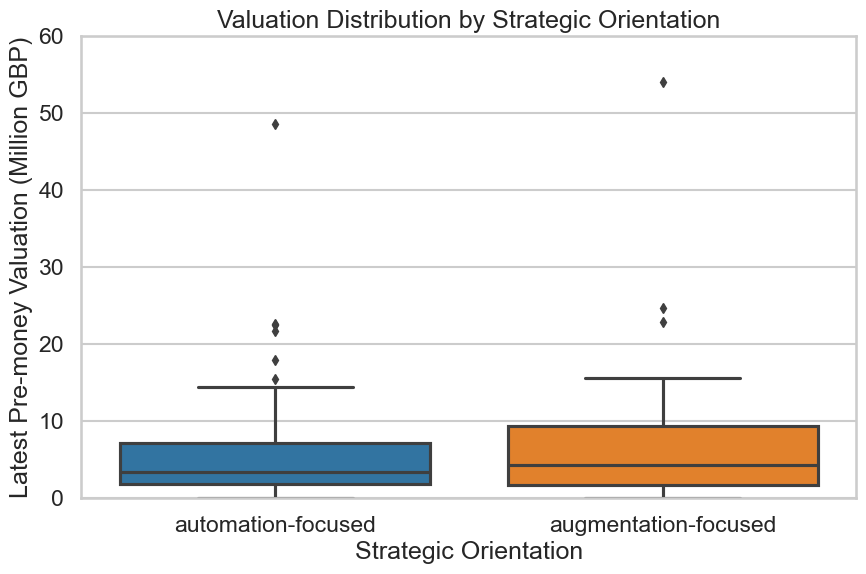

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Latest pre-money valuation' to millions for clarity
ai_startups_dataset['Latest pre-money valuation (Million GBP)'] = ai_startups_dataset['Latest pre-money valuation'] / 1e6

# Set the colors
colors = ['#1f77b4', '#ff7f0e']  # Blue for automation-focused, Orange for augmentation-focused

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=ai_startups_dataset, x='Orientation', y='Latest pre-money valuation (Million GBP)', palette=colors)
plt.title('Valuation Distribution by Strategic Orientation')
plt.xlabel('Strategic Orientation')
plt.ylabel('Latest Pre-money Valuation (Million GBP)')
plt.ylim(0, 60)  # Setting the limit to show outliers up to 60 million

# Show the plot
plt.show()


Grants By Strategic Orientation:
 Orientation
augmentation-focused     7971284.0
automation-focused      14579094.0
Name: Grants - Total amount received by the company through grants (GBP), dtype: float64


/var/folders/vs/p_y2vqv16cbg_ttcxx7q99d00000gn/T/ipykernel_56411/3558015388.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels)


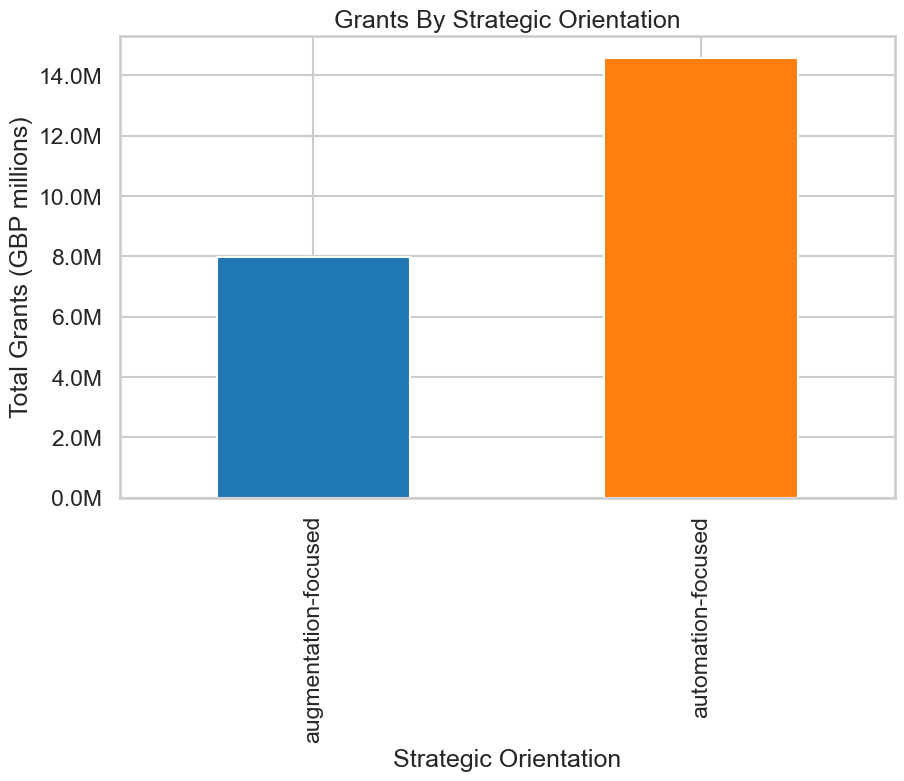

In [330]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the relevant columns to numeric, forcing errors to NaN
ai_startups_dataset['Grants - Total amount received by the company through grants (GBP)'] = pd.to_numeric(ai_startups_dataset['Grants - Total amount received by the company through grants (GBP)'], errors='coerce')

# Summing grants by orientation
grants_by_orientation = ai_startups_dataset.groupby('Orientation')['Grants - Total amount received by the company through grants (GBP)'].sum()

# Print the summary
print("Grants By Strategic Orientation:\n", grants_by_orientation)

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
grants_by_orientation.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Grants By Strategic Orientation')
ax.set_xlabel('Strategic Orientation')
ax.set_ylabel('Total Grants (GBP millions)')

# Adjust the y-axis labels to show values in millions
labels = ax.get_yticks()
new_labels = [f'{label/1e6:.1f}M' for label in labels]
ax.set_yticklabels(new_labels)

# Show the plot
plt.show()


In [334]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
# Assuming 'ai_startups_dataset' is already loaded as a pandas DataFrame

# Creating a contingency table
contingency_table = pd.crosstab(ai_startups_dataset['Sector Group'], ai_startups_dataset['Orientation'])

# Performing the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-square test results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

# Presenting the results
contingency_table


Contingency Table:
Orientation                 augmentation-focused  automation-focused
Sector Group                                                        
Finance                                        2                  13
Green                                          5                  14
Health                                         9                  13
Legal                                          2                   7
Logistics and Supply Chain                     1                  11
Marketing & Advertising                       10                   3
Media & Entertainment                         12                   0
Property                                       4                   5
Retail & Ecommerce                             4                   3
Technology                                     6                  10

Chi-square test results:
Chi2 Statistic: 38.11558755392079
P-value: 1.661837860528247e-05
Degrees of Freedom: 9
Expected Frequencies:
[[ 6.15671642  8.8

Orientation,augmentation-focused,automation-focused
Sector Group,,
Finance,2,13
Green,5,14
Health,9,13
Legal,2,7
Logistics and Supply Chain,1,11
Marketing & Advertising,10,3
Media & Entertainment,12,0
Property,4,5
Retail & Ecommerce,4,3


In [344]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming `ai_startups_dataset` is the DataFrame containing our data
# Example DataFrame creation (since actual data is not provided here)
data = {
    'Sector': ['Health', 'Green', 'Technology', 'Finance', 'Marketing & Advertising', 'Logistics and Supply Chain', 'Media & Entertainment', 'Legal', 'Property', 'Retail & Ecommerce'],
    'Automation-focused': [12, 8, 10, 6, 5, 7, 8, 5, 4, 4],
    'Augmentation-focused': [10, 11, 6, 9, 8, 5, 4, 4, 5, 3]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create contingency table
contingency_table = df.set_index('Sector').T

# Perform Chi-square test
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

contingency_table, chi2_stat, p_val, dof, ex


(Sector                Health  Green  Technology  Finance  \
 Automation-focused        12      8          10        6   
 Augmentation-focused      10     11           6        9   
 
 Sector                Marketing & Advertising  Logistics and Supply Chain  \
 Automation-focused                          5                           7   
 Augmentation-focused                        8                           5   
 
 Sector                Media & Entertainment  Legal  Property  \
 Automation-focused                        8      5         4   
 Augmentation-focused                      4      4         5   
 
 Sector                Retail & Ecommerce  
 Automation-focused                     4  
 Augmentation-focused                   3  ,
 4.864487716056103,
 0.8459575371972248,
 9,
 array([[11.32835821,  9.78358209,  8.23880597,  7.7238806 ,  6.69402985,
          6.17910448,  6.17910448,  4.63432836,  4.63432836,  3.60447761],
        [10.67164179,  9.21641791,  7.76119403,  7.2761

In [338]:
import pandas as pd
import scipy.stats as stats

# Sample DataFrame
data = {
    'industry_sector': ['Health', 'Green', 'Technology', 'Finance', 'Marketing & Advertising', 
                        'Logistics and Supply Chain', 'Media & Entertainment', 'Legal', 
                        'Property', 'Retail & Ecommerce', 'Health', 'Green', 'Technology', 
                        'Finance', 'Marketing & Advertising', 'Logistics and Supply Chain', 
                        'Media & Entertainment', 'Legal', 'Property', 'Retail & Ecommerce'],
    'strategic_orientation': ['automation-focused', 'automation-focused', 'augmentation-focused', 
                              'automation-focused', 'augmentation-focused', 'augmentation-focused', 
                              'automation-focused', 'augmentation-focused', 'automation-focused', 
                              'augmentation-focused', 'automation-focused', 'augmentation-focused', 
                              'automation-focused', 'automation-focused', 'augmentation-focused', 
                              'automation-focused', 'automation-focused', 'augmentation-focused', 
                              'automation-focused', 'augmentation-focused']
}

df = pd.DataFrame(data)

# Create contingency table
contingency_table = pd.crosstab(df['industry_sector'], df['strategic_orientation'])

print("Contingency Table:")
print(contingency_table)


Contingency Table:
strategic_orientation       augmentation-focused  automation-focused
industry_sector                                                     
Finance                                        0                   2
Green                                          1                   1
Health                                         0                   2
Legal                                          2                   0
Logistics and Supply Chain                     1                   1
Marketing & Advertising                        2                   0
Media & Entertainment                          0                   2
Property                                       0                   2
Retail & Ecommerce                             2                   0
Technology                                     1                   1


In [340]:
# Perform Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("\nChi-square Test Results:")
print(f"Chi-square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi-square Test Results:
Chi-square Statistic: 13.93939393939394
p-value: 0.1244974943251587
Degrees of Freedom: 9
Expected Frequencies:
[[0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]
 [0.9 1.1]]


In [342]:
import ace_tools as tools

tools.display_dataframe_to_user(name="Contingency Table", dataframe=contingency_table)

# Prepare the results for the thesis
contingency_table_str = contingency_table.to_string()
expected_str = pd.DataFrame(expected, columns=contingency_table.columns, index=contingency_table.index).to_string()

print("\n### Contingency Table:\n")
print(contingency_table_str)
print("\n### Chi-square Test Results:\n")
print(f"Chi-square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\n### Expected Frequencies:\n")
print(expected_str)


ModuleNotFoundError: No module named 'ace_tools'

In [356]:
ai_startups_dataset.head()

,Orientation,Company Name,Web URL,Sector,AI Use Case,Purpose,customer,tech_stack,value,Latest pre-money valuation,...,prolific_investor,large_investor,us_investor,Funding before Q1 2022,Funding after Q1 2022,Incorporation date (Companies House),Sector Group,Total Funding,Incorporation Year,Latest pre-money valuation (Million GBP)
0,automation-focused,Novai,https://www.novai.co.uk/,Health,AI to detect the DARC biomarker in retina images,event detection,third,sensors,unclear,1.360501e+07,...,1.0,NaN,NaN,9.971827e+06,2.263302e+07,2020-02-12,Health,3.260485e+07,2020,13.605012
1,augmentation-focused,UNTAP,https://www.untap.pe/,Finance,AI predicts the future performance and cash fl...,forecasting,b2b,services,unclear,2.475874e+06,...,1.0,NaN,NaN,3.182400e+04,4.595472e+06,2021-04-23,Finance,4.627296e+06,2021,2.475874
2,augmentation-focused,Kuano,https://www.kuano.ai/,Health,AI to faciliate the addition of quantum mechan...,optimisation,third,services,unclear,4.119353e+06,...,NaN,NaN,NaN,4.000000e+06,6.508310e+06,2020-02-17,Health,1.050831e+07,2020,4.119353
3,augmentation-focused,RegGenome,reg-genome.com,Finance,AI predicts and organises relevant financial r...,forecasting,b2b,api data_management,unclear,1.035370e+07,...,1.0,NaN,1.0,5.699927e+06,3.739987e+07,2020-09-07,Finance,4.309980e+07,2020,10.353699
4,augmentation-focused,iLoF - intelligent Lab on Fiber,ilof.tech,Health,"AI predicts type of exosome (a small, membrane...",recognition,b2b,services,unclear,1.221685e+07,...,1.0,1.0,1.0,9.738467e+06,3.333847e+07,2020-05-22,Health,4.307693e+07,2020,12.216850


In [358]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming ai_startups_dataset is the DataFrame containing our data
# We need to filter the dataframe to get the relevant columns for analysis

# Filter data for automation-focused and augmentation-focused startups
automation_focused = ai_startups_dataset[ai_startups_dataset['Orientation'] == 'automation-focused']
augmentation_focused = ai_startups_dataset[ai_startups_dataset['Orientation'] == 'augmentation-focused']

# Extract the total funding amounts for each group
automation_funding = automation_focused['Total Funding']
augmentation_funding = augmentation_focused['Total Funding']

# Perform two-sample t-test
t_stat, p_val = ttest_ind(automation_funding, augmentation_funding, equal_var=False) # Use equal_var=False if variances are unequal

# Output the results
print(f"t-statistic: {t_stat}, p-value: {p_val}")

# Display the means for additional context
mean_automation_funding = automation_funding.mean()
mean_augmentation_funding = augmentation_funding.mean()

print(f"Mean funding for automation-focused startups: {mean_automation_funding}")
print(f"Mean funding for augmentation-focused startups: {mean_augmentation_funding}")


t-statistic: -1.11308738382789, p-value: 0.2686843682254911
Mean funding for automation-focused startups: 15401741.247680254
Mean funding for augmentation-focused startups: 21615072.907133456


In [362]:
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'ai_startups_dataset' is the DataFrame containing your data

# Convert the boolean columns to integer (1 for True, 0 for False)
ai_startups_dataset['academic_founders'] = ai_startups_dataset['academic_founders'].astype(int)
ai_startups_dataset['expert_founders'] = ai_startups_dataset['expert_founders'].astype(int)
ai_startups_dataset['serial_founders'] = ai_startups_dataset['serial_founders'].astype(int)

# Create a new DataFrame to store the counts
founder_orientation_counts = pd.DataFrame({
    'academic_automation': ai_startups_dataset[ai_startups_dataset['Orientation'] == 'automation-focused']['academic_founders'].sum(),
    'academic_augmentation': ai_startups_dataset[ai_startups_dataset['Orientation'] == 'augmentation-focused']['academic_founders'].sum(),
    'expert_automation': ai_startups_dataset[ai_startups_dataset['Orientation'] == 'automation-focused']['expert_founders'].sum(),
    'expert_augmentation': ai_startups_dataset[ai_startups_dataset['Orientation'] == 'augmentation-focused']['expert_founders'].sum(),
    'serial_automation': ai_startups_dataset[ai_startups_dataset['Orientation'] == 'automation-focused']['serial_founders'].sum(),
    'serial_augmentation': ai_startups_dataset[ai_startups_dataset['Orientation'] == 'augmentation-focused']['serial_founders'].sum()
}, index=['Count']).T

# Reshape the DataFrame to match the expected input for chi2_contingency
contingency_table = pd.DataFrame({
    'automation-focused': [founder_orientation_counts.loc['academic_automation'].values[0], 
                           founder_orientation_counts.loc['expert_automation'].values[0], 
                           founder_orientation_counts.loc['serial_automation'].values[0]],
    'augmentation-focused': [founder_orientation_counts.loc['academic_augmentation'].values[0], 
                             founder_orientation_counts.loc['expert_augmentation'].values[0], 
                             founder_orientation_counts.loc['serial_augmentation'].values[0]]
}, index=['academic_founders', 'expert_founders', 'serial_founders'])

# Perform Chi-square test
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

contingency_table, chi2_stat, p_val, dof, ex


(                   automation-focused  augmentation-focused
 academic_founders                  19                    16
 expert_founders                    40                    33
 serial_founders                    11                    14,
 0.9225101108936722,
 0.6304918465088912,
 2,
 array([[18.42105263, 16.57894737],
        [38.42105263, 34.57894737],
        [13.15789474, 11.84210526]]))